In [1]:
import sys
sys.path.append('..')

import uproot

import numpy as np
import pandas as pd
import awkward as ak
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.measure import label, regionprops
from scipy.ndimage import label as scipy_label
from collections import deque

from lariat import Event

In [2]:
deuterons = pd.read_csv('/Users/user/data/research/proton-deuteron/csv/deuteron_candidates_bbox_t100.csv') # from within vertices bounding box
pickydeuterons = pd.read_csv("/Users/user/data/research/proton-deuteron/csv/pickydeuterons.csv")

In [3]:
allclusters = pd.read_pickle("/Users/user/data/research/proton-deuteron/csv/allclusters.pkl")

In [4]:
allclusters

event_idx   run  subrun  event  \
0               0  8667     148  10828   
1               0  8667     148  10828   
2               0  8667     148  10828   
3               0  8667     148  10828   
4               0  8667     148  10828   
...           ...   ...     ...    ...   
438570       7635  9788     311  27225   
438571       7635  9788     311  27225   
438572       7635  9788     311  27225   
438573       7635  9788     311  27225   
438574       7635  9788     311  27225   

                                                file_path  event_index  \
0       /Users/user/data/research/proton-deuteron/rawd...            0   
1       /Users/user/data/research/proton-deuteron/rawd...            0   
2       /Users/user/data/research/proton-deuteron/rawd...            0   
3       /Users/user/data/research/proton-deuteron/rawd...            0   
4       /Users/user/data/research/proton-deuteron/rawd...            0   
...                                                   ...          ...   
438570  /Users/user/data/research/proton-deuteron/rawp...            0   
438571  /Users/user/data/research/proton-deuteron/rawp...            0   
438572  /Users/user/data/research/proton-deuteron/rawp...            0   
438573  /Users/user/data/research/proton-deuteron/rawp...            0   
438574  /Users/user/data/research/proton-deuteron/rawp...            0   

       particle_type       plane  cluster_idx    area  ...  bbox_min_col  \
0           deuteron  collection            0  9047.0  ...           154   
1           deuteron  collection            1    22.0  ...           888   
2           deuteron  collection            2    29.0  ...           484   
3           deuteron  collection            3    24.0  ...           369   
4           deuteron  collection            4    31.0  ...           188   
...              ...         ...          ...     ...  ...           ...   
438570        proton  collection            4    31.0  ...          2570   
438571        proton  collection            5    27.0  ...           277   
438572        proton   induction            0  1559.0  ...          1101   
438573        proton   induction            1    24.0  ...          2707   
438574        proton   induction            2    22.0  ...           256   

        bbox_max_row  bbox_max_col  width  height  aspect_ratio  compactness  \
0                196           944    790     171      4.619883     0.066970   
1                 36           910     22       1     22.000000     1.000000   
2                174           513     29       1     29.000000     1.000000   
3                197           393     24       1     24.000000     1.000000   
4                198           219     31       1     31.000000     1.000000   
...              ...           ...    ...     ...           ...          ...   
438570            93          2601     31       1     31.000000     1.000000   
438571           115           304     27       1     27.000000     1.000000   
438572            83          1239    138      56      2.464286     0.201734   
438573            79          2731     24       1     24.000000     1.000000   
438574            90           278     22       1     22.000000     1.000000   

                                          image_intensity  \
0       [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1       [[16.0, 18.0, 20.0, 21.0, 23.0, 24.0, 25.0, 26...   
2       [[16.0, 18.0, 19.0, 21.0, 23.0, 25.0, 27.0, 28...   
3       [[16.0, 16.0, 16.0, 17.0, 17.0, 17.0, 17.0, 18...   
4       [[17.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0, 32...   
...                                                   ...   
438570  [[16.0, 18.0, 19.0, 21.0, 23.0, 24.0, 26.0, 27...   
438571  [[16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 29...   
438572  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
438573  [[17.0, 19.0, 22.0, 25.0, 27.0, 30.0, 33.0, 35...   
438574  [[16.0, 19.0, 20.0, 23.0, 25.0, 28.0, 29.0, 31...   

       

In [5]:
picky = pd.merge(deuterons,
                 pickydeuterons,
                 on=['run', 'subrun', 'event'],
                 how='inner')

picky = picky.drop_duplicates(subset=['run', 'subrun', 'event']).reset_index(drop=True)

picky.head()

run  subrun  event                                          file_path  \
0  8596     410  37727  /Users/user/data/research/proton-deuteron/rawd...   
1  9473     109   9096  /Users/user/data/research/proton-deuteron/rawd...   
2  9783      28   4265  /Users/user/data/research/proton-deuteron/rawd...   
3  8667      39   2811  /Users/user/data/research/proton-deuteron/rawd...   
4  9481     248  19285  /Users/user/data/research/proton-deuteron/rawd...   

   event_index  col_max_adc  ind_max_adc  col_activity_pixels  \
0            0         94.0         42.0                   52   
1            0        162.0        127.0                  730   
2            0        396.0        192.0                  775   
3            0        126.0        101.0                  245   
4            0        243.0        120.0                  923   

   ind_activity_pixels  p  m  beamline_mass  
0                    0  1  0        1822.06  
1                   84  1  0        1869.80  
2                  109  1  0        1826.83  
3                  188  1  1        2032.23  
4                  107  1  0        2331.43

In [6]:
i = 186
row = picky.iloc[i]

In [7]:
row

run                                                                 8557
subrun                                                               168
event                                                               7815
file_path              /Users/user/data/research/proton-deuteron/rawd...
event_index                                                            0
col_max_adc                                                        309.0
ind_max_adc                                                        159.0
col_activity_pixels                                                  760
ind_activity_pixels                                                  264
p                                                                      1
m                                                                      1
beamline_mass                                                    1989.77
Name: 186, dtype: object

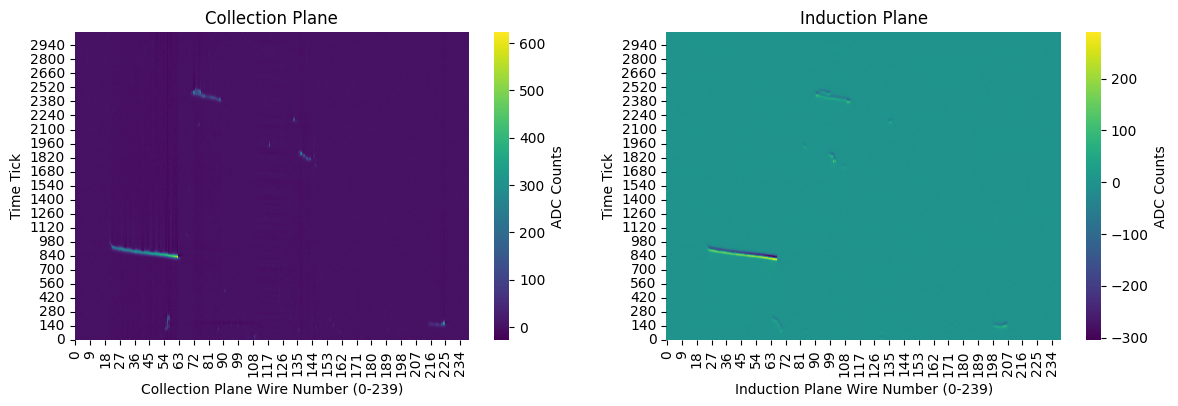

In [8]:
event = Event(row['file_path'], row['event_index'], threshold=15)

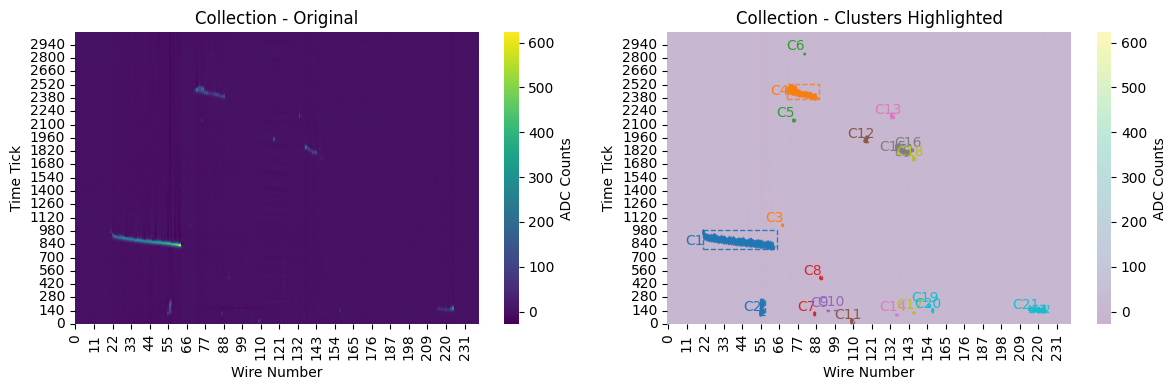

In [9]:
event.visualiseclusters(event.collection, event.connectedcr, 'Collection', mode='highlight')

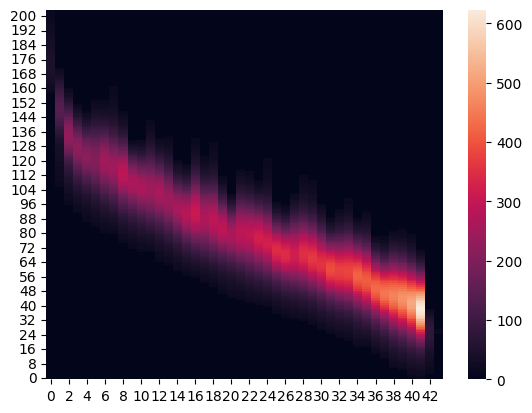

In [10]:
c = 0
sns.heatmap(event.connectedcr[c].image_intensity.T)
plt.gca().invert_yaxis()

This would not make it becuase of length cut on the clusters that I had used to remove actual noise.

In [11]:
maxing = np.max(event.connectedcr[c].image_intensity.T, axis=0)
maxing

array([ 46., 138., 228., 222., 216., 205., 249., 248., 289., 265., 262.,
       247., 261., 247., 260., 282., 309., 271., 292., 289., 264., 290.,
       297., 322., 323., 344., 345., 322., 349., 364., 356., 391., 378.,
       383., 418., 411., 427., 445., 460., 483., 515., 623.,  80.,  16.])

In [12]:
normalised = []

minimum = 0
maximum = np.max(maxing)

if maximum > minimum:
    normalised_signal = (maxing - minimum) / (maximum - minimum)
else:
    normalised_signal = np.zeros_like(maxing, dtype=float)
    print('Error: Max not greater than min in signal.')
normalised.append(normalised_signal)

adcdiff = [np.diff(signal) for signal in normalised]; 
maxdiff = [np.max(diff) for diff in adcdiff]; 

In [13]:
normalised

[array([0.07383628, 0.22150883, 0.36597111, 0.35634029, 0.34670947,
        0.32905297, 0.39967897, 0.39807384, 0.46388443, 0.42536116,
        0.42054575, 0.3964687 , 0.41894061, 0.3964687 , 0.41733547,
        0.45264848, 0.49598716, 0.43499197, 0.46869984, 0.46388443,
        0.42375602, 0.46548957, 0.47672552, 0.51685393, 0.51845907,
        0.55216693, 0.55377207, 0.51685393, 0.56019262, 0.58426966,
        0.57142857, 0.62760835, 0.60674157, 0.61476726, 0.67094703,
        0.65971108, 0.68539326, 0.71428571, 0.73836276, 0.7752809 ,
        0.82664526, 1.        , 0.12841091, 0.02568218])]

In [14]:
adcdiff

[array([ 0.14767255,  0.14446228, -0.00963082, -0.00963082, -0.0176565 ,
         0.070626  , -0.00160514,  0.06581059, -0.03852327, -0.00481541,
        -0.02407705,  0.02247191, -0.02247191,  0.02086677,  0.035313  ,
         0.04333868, -0.06099518,  0.03370787, -0.00481541, -0.04012841,
         0.04173355,  0.01123596,  0.04012841,  0.00160514,  0.03370787,
         0.00160514, -0.03691814,  0.04333868,  0.02407705, -0.01284109,
         0.05617978, -0.02086677,  0.00802568,  0.05617978, -0.01123596,
         0.02568218,  0.02889246,  0.02407705,  0.03691814,  0.05136437,
         0.17335474, -0.87158909, -0.10272873])]

In [15]:
maxdiff

[np.float64(0.173354735152488)]

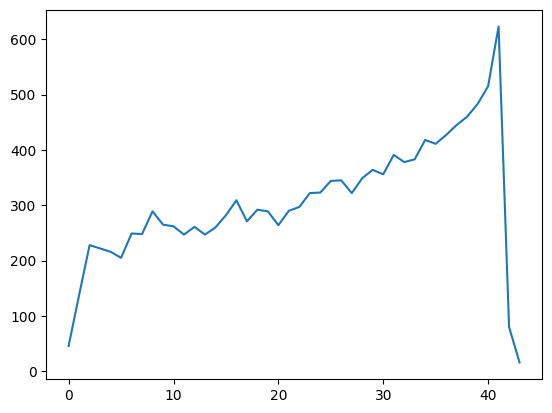

In [16]:
plt.plot(maxing)
plt.show()

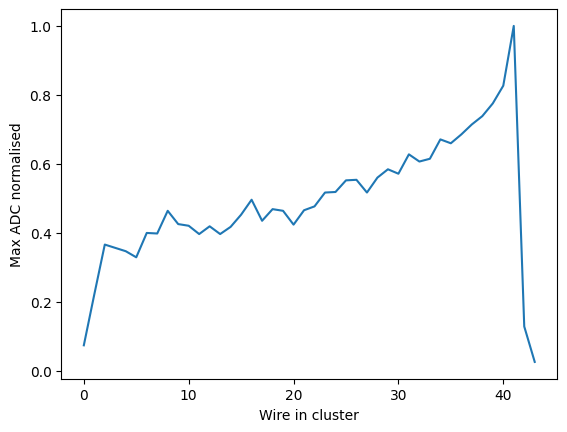

In [17]:
plt.plot(normalised[0]); plt.xlabel('Wire in cluster'); plt.ylabel('Max ADC normalised'); plt.show()

All clusters

In [18]:
clusters = pd.merge(allclusters,
                 pickydeuterons,
                 on=['run', 'subrun', 'event'],
                 how='inner')

# clusters = clusters.drop_duplicates(subset=['run', 'subrun', 'event']).reset_index(drop=True)

In [19]:
# clusters = clusters.groupby(['run', 'subrun', 'event'])

In [20]:
clusters = clusters.sort_values(['run', 'subrun', 'event']).set_index(['run', 'subrun', 'event'])

In [21]:
i = 6
g = picky[['run', 'subrun', 'event']].iloc[i]
cs = clusters.loc[tuple(g)]

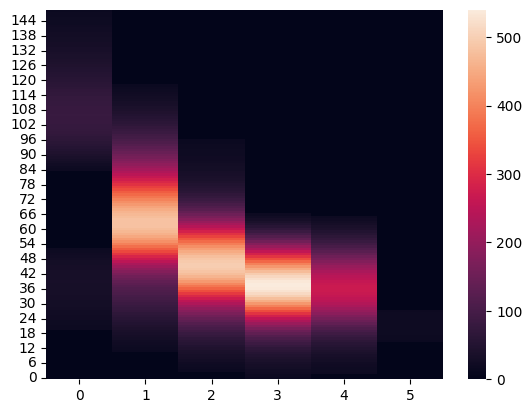

In [22]:
c = 1
t = cs.iloc[c]
sns.heatmap(t.image_intensity.T)
plt.gca().invert_yaxis()

Seperating Protons and Muons

In [23]:
lcut = allclusters[
    (allclusters['column_maxes'].map(len) > 1) &
    (allclusters['column_maxes'].map(lambda x: len(set(x)) > 1))
    ].reset_index(drop=True)

print(allclusters.shape); print(lcut.shape) 


(438575, 27)
(203482, 27)


In [24]:
maxes = lcut['column_maxes'].values; len(maxes)

203482

In [25]:
normalised = []

for i, signal in enumerate(maxes):
    minimum = 0
    maximum = np.max(signal)

    if maximum > minimum:
        normalised_signal = (signal - minimum) / (maximum - minimum)
    else:
        normalised_signal = np.zeros_like(signal, dtype=float)
        print(f'Error: Max not greater than min in signal {i}.')
    normalised.append(normalised_signal)

lcut['normalised'] = normalised
adcdiff = [np.diff(signal) for signal in normalised]; lcut['adcdiff'] = adcdiff
maxdiff = [np.max(diff) for diff in adcdiff]; lcut['maxdiff'] = maxdiff

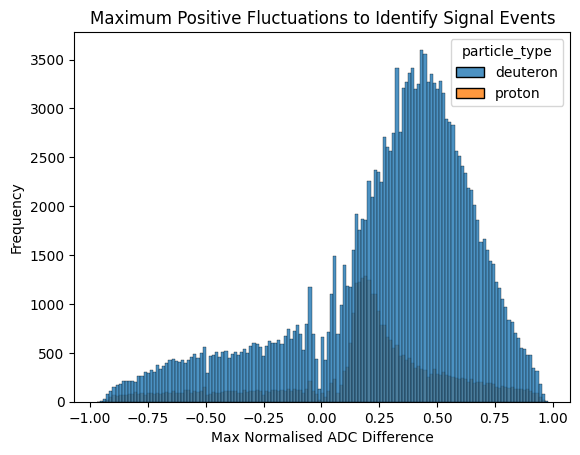

In [26]:
plt.figure()

sns.histplot(data=lcut,
             x='maxdiff',
             hue='particle_type',
             bins='auto',
             alpha=0.8)

# plt.axvline(0.26, color='red', linestyle=':' )

plt.xlabel('Max Normalised ADC Difference')
plt.ylabel('Frequency')
plt.title('Maximum Positive Fluctuations to Identify Signal Events')
plt.show()

# Clusters with negative maxdiff

In [27]:
negatives = lcut[lcut['maxdiff'] < 0].reset_index(drop=True)

In [28]:
negatives.shape

(38236, 30)

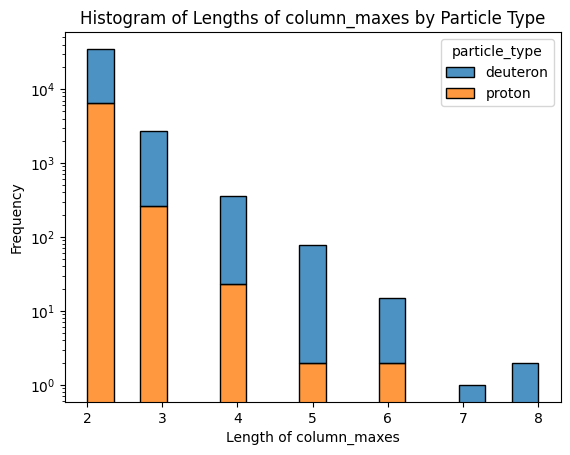

(array([  137,  1695,  1965, 12962, 17295, 17397, 17489, 18028, 22096,
        22634, 26529, 29786, 30667, 32181, 35470]),)

In [29]:
lengths = negatives['column_maxes'].map(len)
negatives['lengths'] = lengths  # Add as a column for seaborn

plt.figure()
sns.histplot(data=negatives, x='lengths', hue='particle_type', bins='auto', multiple='stack', alpha=0.8)
plt.xlabel('Length of column_maxes')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Histogram of Lengths of column_maxes by Particle Type')
plt.show()

a = np.where(lengths == 6)
a

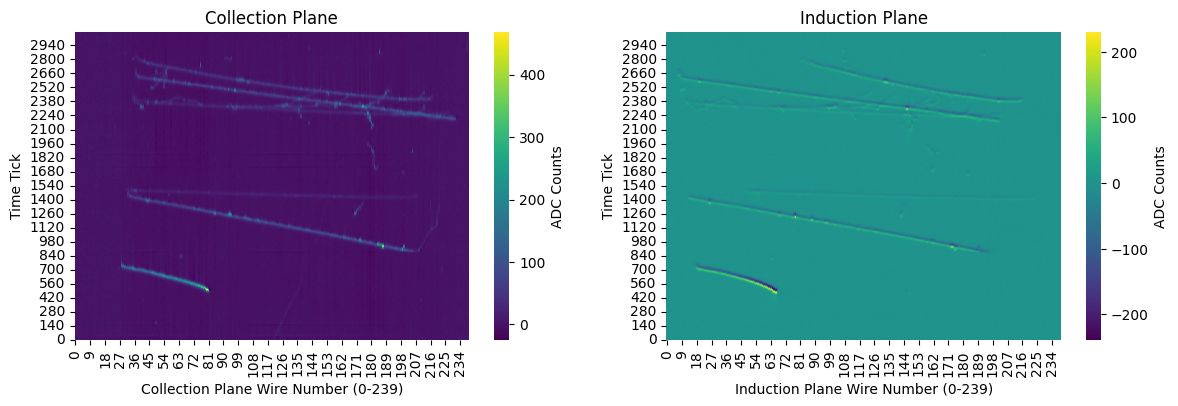

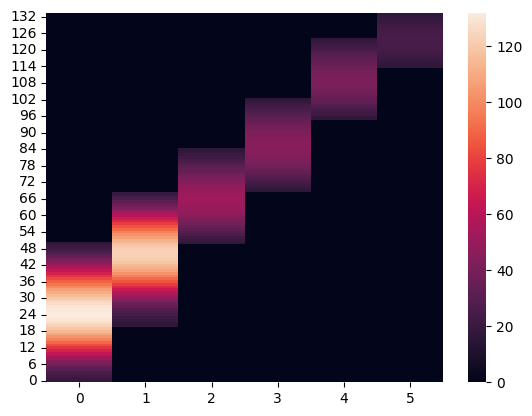

In [30]:
i = 22096
negative = Event(negatives.iloc[i]['file_path'], negatives.iloc[i]['event_index'])
sns.heatmap(negatives.iloc[i]['image_intensity'].T)
plt.gca().invert_yaxis()

Negatives are all noise. Remove.

In [31]:
ncut = lcut[lcut['maxdiff'] >= 0].reset_index(drop=True)

# Separating protons, deuterons and muons and noise.

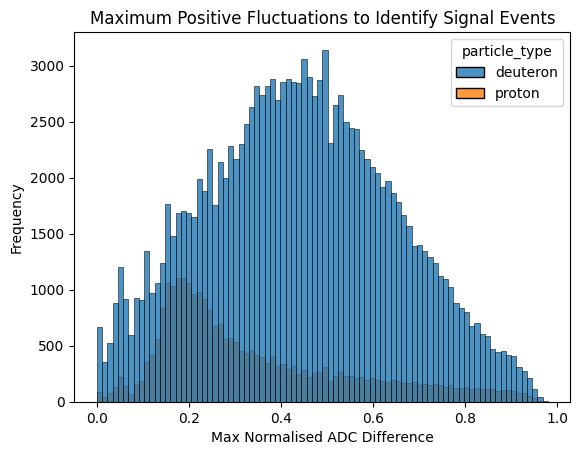

In [32]:
plt.figure()

sns.histplot(data=ncut,
             x='maxdiff',
             hue='particle_type',
             bins='auto',
             alpha=0.8)

# plt.axvline(0.26, color='red', linestyle=':' )

plt.xlabel('Max Normalised ADC Difference')
plt.ylabel('Frequency')
plt.title('Maximum Positive Fluctuations to Identify Signal Events')
plt.show()

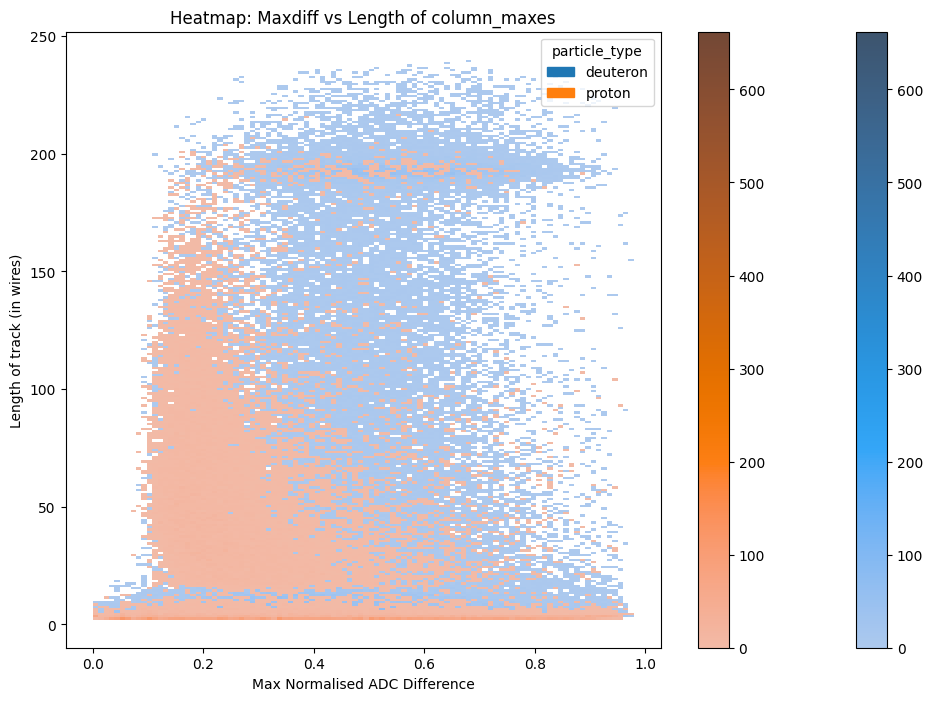

In [33]:
ncut['lengths'] = ncut['column_maxes'].map(len)

plt.figure(figsize=(12,8))
sns.histplot(data=ncut, x='maxdiff', y='lengths', hue='particle_type', bins=[100, 239], cbar=True)
plt.xlabel('Max Normalised ADC Difference')
plt.ylabel('Length of track (in wires)')
plt.title('Heatmap: Maxdiff vs Length of column_maxes')
plt.show()

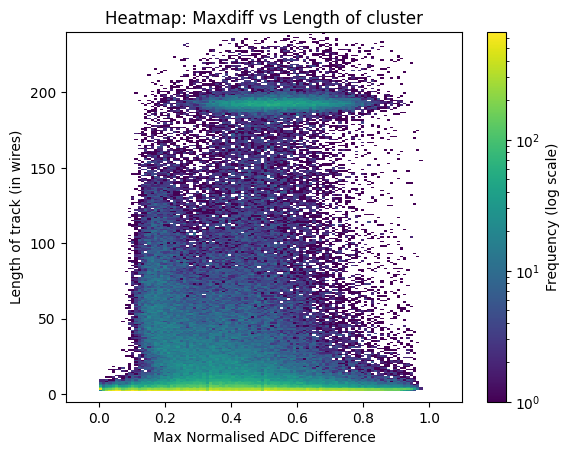

In [34]:
from matplotlib.colors import LogNorm

plt.figure()
h = plt.hist2d(ncut['maxdiff'], ncut['lengths'], bins=[100, 239], norm=LogNorm(), cmap='viridis')
plt.xlabel('Max Normalised ADC Difference')
plt.ylabel('Length of track (in wires)')
plt.ylim(-5, 240)
plt.xlim(-0.1,1.1)
plt.title('Heatmap: Maxdiff vs Length of cluster')
plt.colorbar(label='Frequency (log scale)')
plt.show()


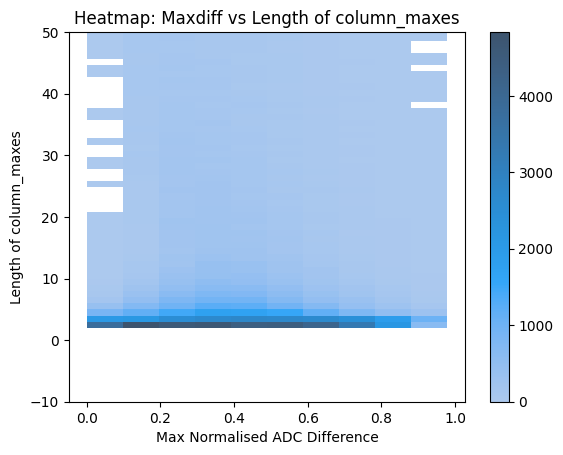

In [35]:
ncut['lengths'] = ncut['column_maxes'].map(len)

plt.figure()
sns.histplot(data=ncut, x='maxdiff', y='lengths', bins=[10, 240], cbar=True)
plt.xlabel('Max Normalised ADC Difference')
plt.ylabel('Length of column_maxes')
plt.ylim(-10, 50)
plt.title('Heatmap: Maxdiff vs Length of column_maxes')
plt.show()

[]

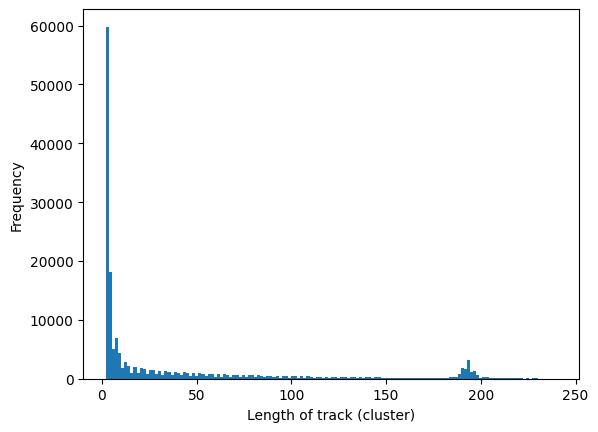

In [36]:
a = plt.hist(ncut['lengths'], bins='auto'); plt.xlabel('Length of track (cluster)'); plt.ylabel('Frequency')
plt.plot()
# len(a[0])

[]

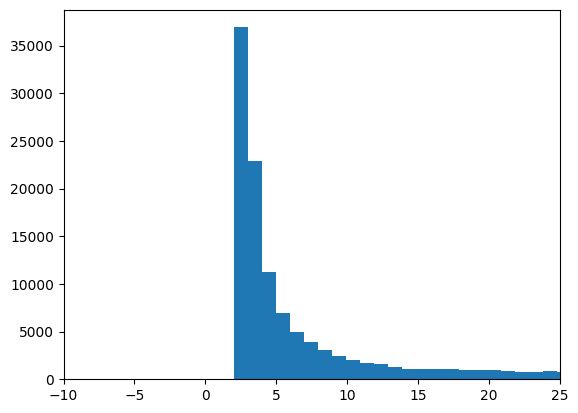

In [37]:
plt.hist(ncut['lengths'], bins=240)
plt.xlim(-10, 25)
plt.plot()

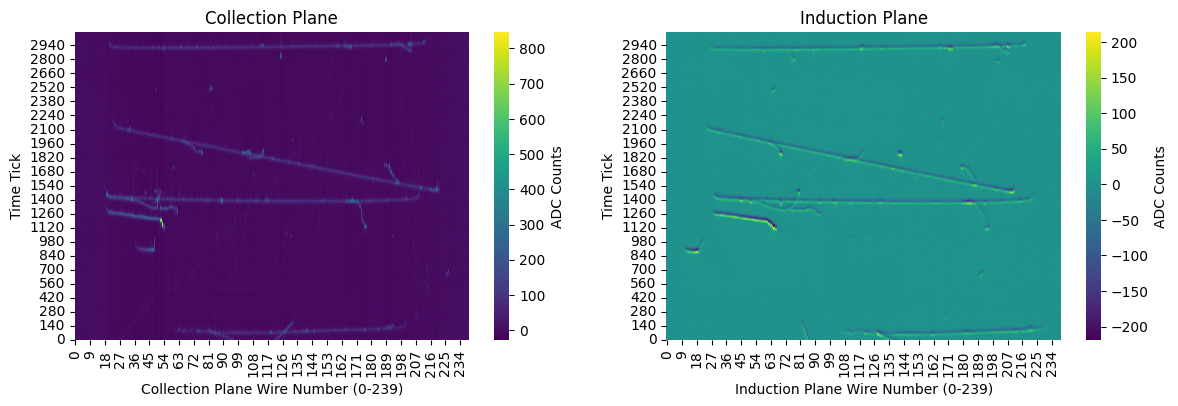

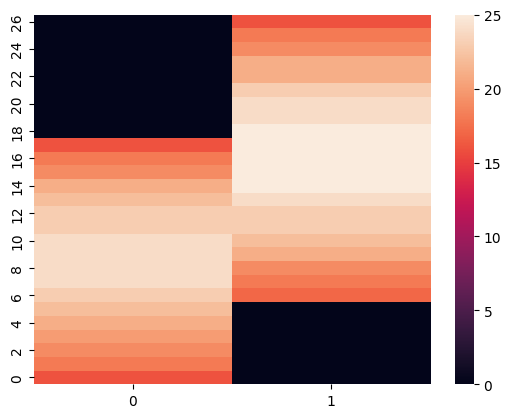

In [38]:
l2 = ncut[ncut['lengths'] == 2].reset_index(drop=True)

i = 1200
event = Event(l2.iloc[i]['file_path'], l2.iloc[i]['event_index'])
sns.heatmap(l2.iloc[i]['image_intensity'].T)
plt.gca().invert_yaxis()

These are all noise. 

In [39]:
l2cut = ncut[ncut['lengths'] > 2].reset_index(drop=True)

(22894, 31)


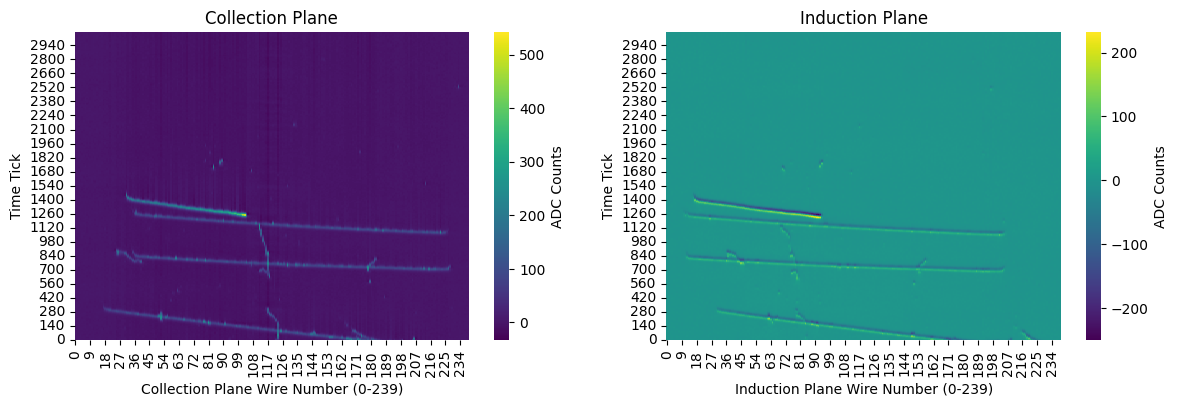

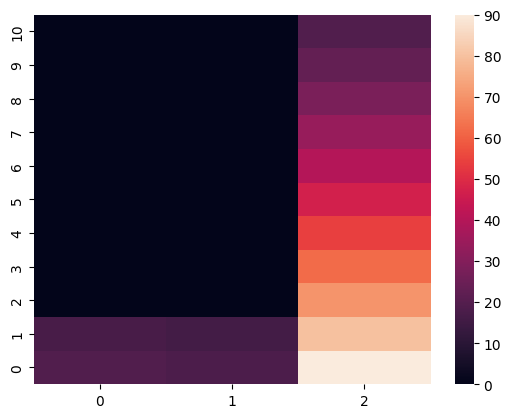

In [40]:
l3 = ncut[ncut['lengths'] == 3].reset_index(drop=True); print(l3.shape)

i = 0
row = l3.sample(n=1)
event = Event(row.iloc[i]['file_path'], row.iloc[i]['event_index'])
sns.heatmap(row.iloc[i]['image_intensity'].T)
plt.gca().invert_yaxis()

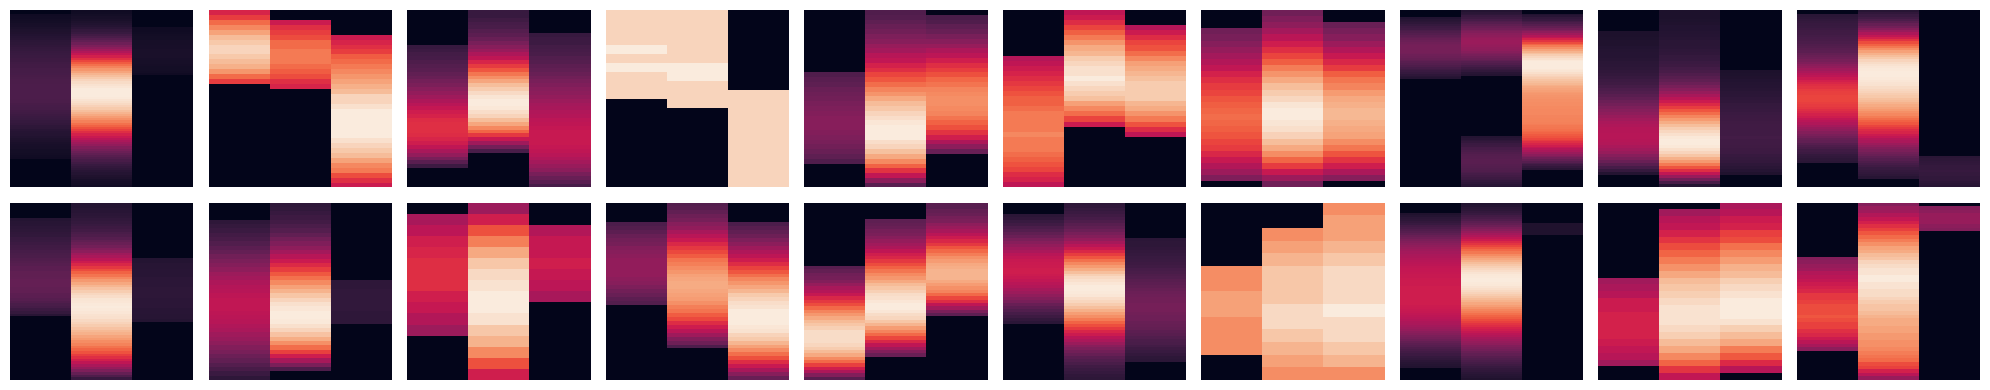

In [41]:
l3 = l3.sample(n=20)
n = 10  # grid size (change as needed)
fig, axes = plt.subplots(2, n, figsize=(20, 4))
for idx, ax in enumerate(axes.flat):
    if idx >= len(l3):
        break
    sns.heatmap(l3.iloc[idx]['image_intensity'].T, ax=ax, cbar=False)
    ax.axis('off')
plt.tight_layout()
plt.show()

Treating this as noise as well.

In [42]:
l3cut = l2cut[l2cut['lengths'] > 3].reset_index(drop=True); print(l3cut.shape)

(105441, 31)


In [43]:
bboxcut = l3cut[(l3cut['plane'] == 'collection') & (l3cut['bbox_min_row'] > 11) & (l3cut['bbox_min_row'] < 35) & (l3cut['bbox_max_col'] > 786) & (l3cut['bbox_max_col'] < 1794)].reset_index(drop=True); print(bboxcut.shape) # collection plane only

(14541, 31)


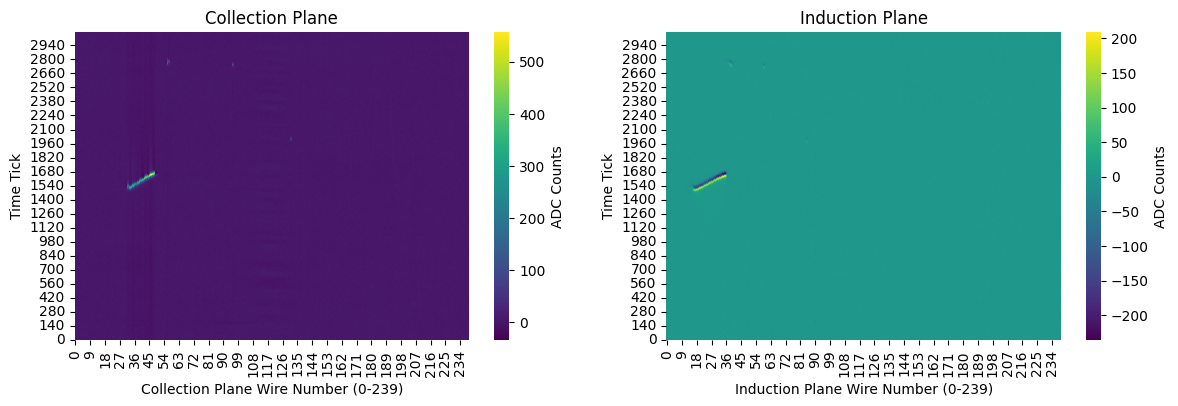

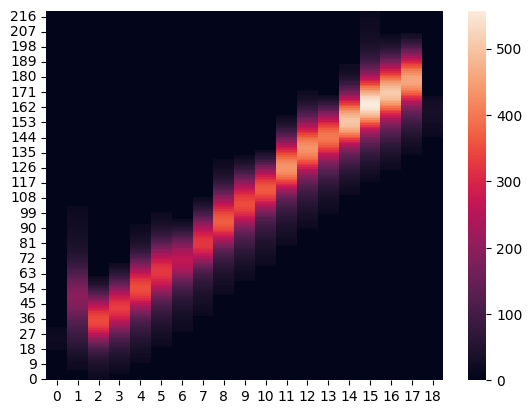

In [44]:
i = 0
row = bboxcut.sample(n=1)
event = Event(row.iloc[i]['file_path'], row.iloc[i]['event_index'])
sns.heatmap(row.iloc[i]['image_intensity'].T)
plt.gca().invert_yaxis()

In [45]:
l180cut = bboxcut[bboxcut['lengths'] < 180].reset_index(drop=True); print(l180cut.shape)

(12162, 31)


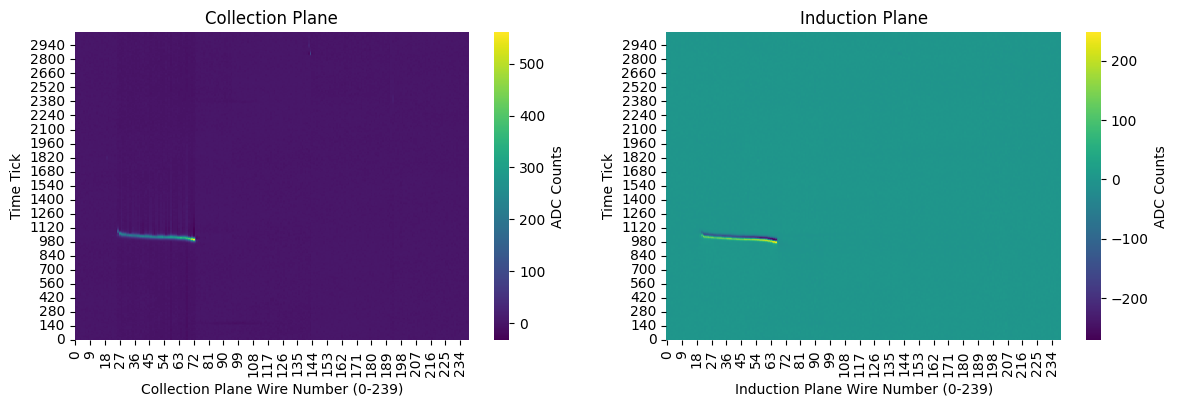

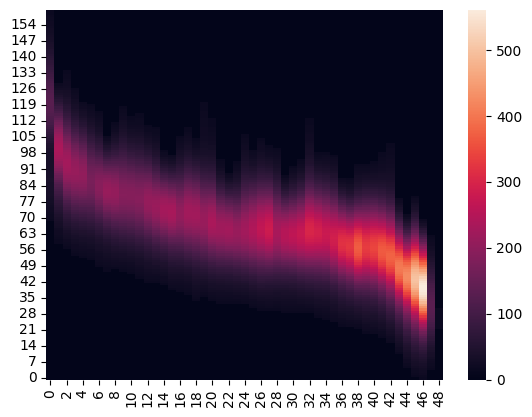

In [46]:
i = 0
row = l180cut.sample(n=1)
event = Event(row.iloc[i]['file_path'], row.iloc[i]['event_index'])
sns.heatmap(row.iloc[i]['image_intensity'].T)
plt.gca().invert_yaxis()

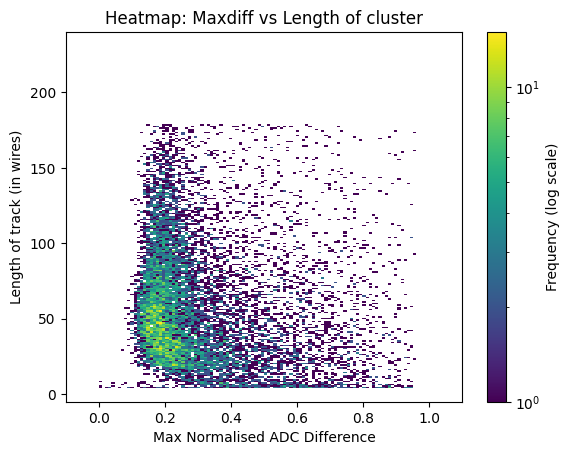

In [47]:
plt.figure()
h = plt.hist2d(l180cut['maxdiff'], l180cut['lengths'], bins=[100, 176], norm=LogNorm(), cmap='viridis')
plt.xlabel('Max Normalised ADC Difference')
plt.ylabel('Length of track (in wires)')
plt.ylim(-5, 240)
plt.xlim(-0.1,1.1)
plt.title('Heatmap: Maxdiff vs Length of cluster')
plt.colorbar(label='Frequency (log scale)')
plt.show()

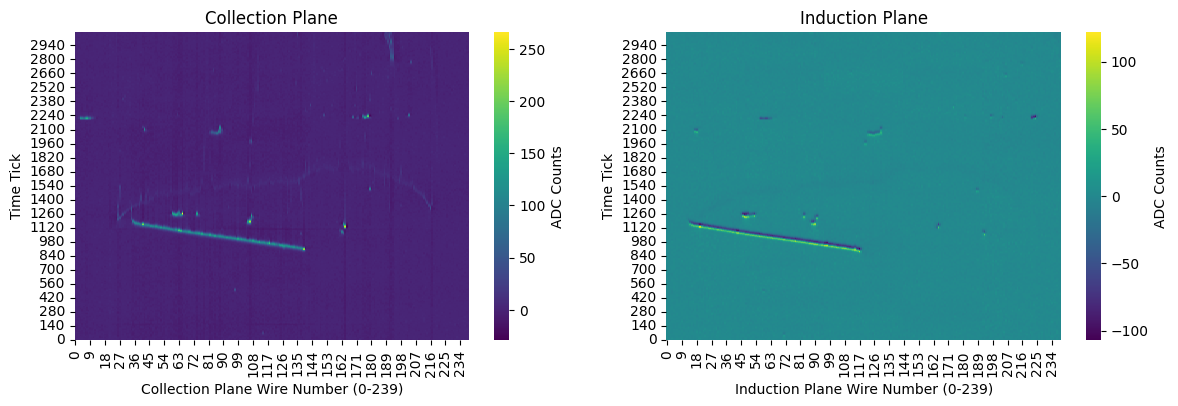

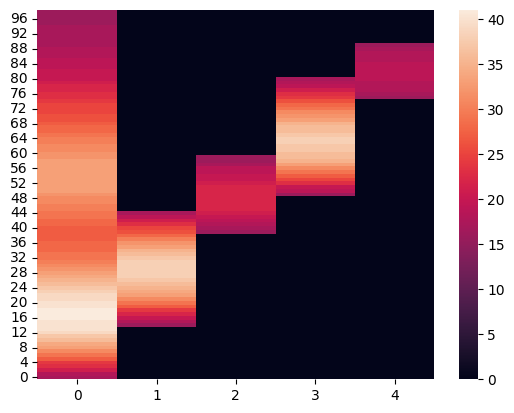

In [48]:
l5 = l180cut[l180cut['lengths'] == 5].reset_index(drop=True)

i = 0
row = l5.sample(n=1)
event = Event(row.iloc[i]['file_path'], row.iloc[i]['event_index'])
sns.heatmap(row.iloc[i]['image_intensity'].T)
plt.gca().invert_yaxis()

In [49]:
np.min(l5['max_intensity'])

np.float64(21.0)

[]

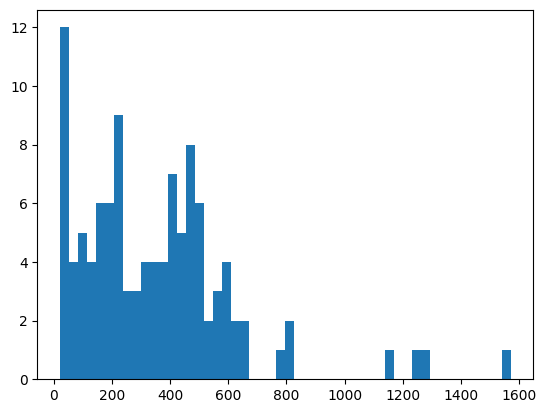

In [50]:
plt.hist(l5['max_intensity'], bins=50)
plt.plot()

(125, 31)


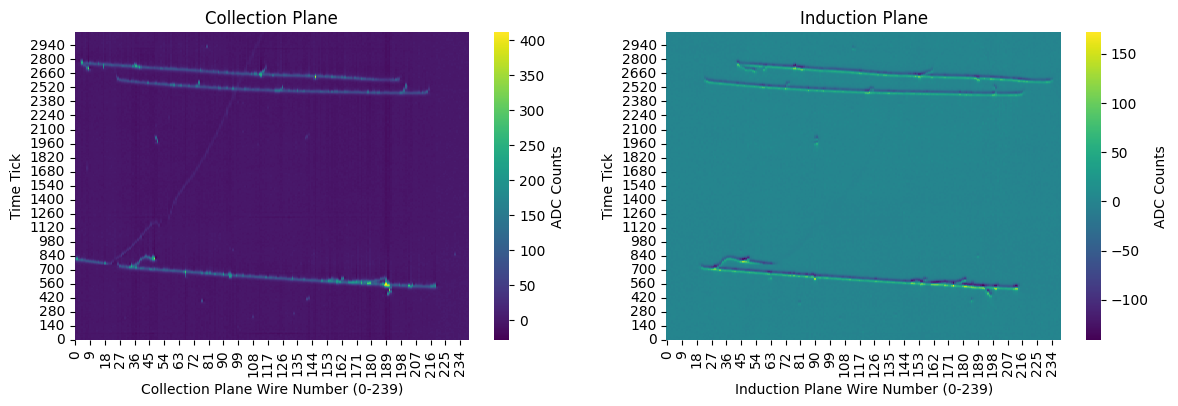

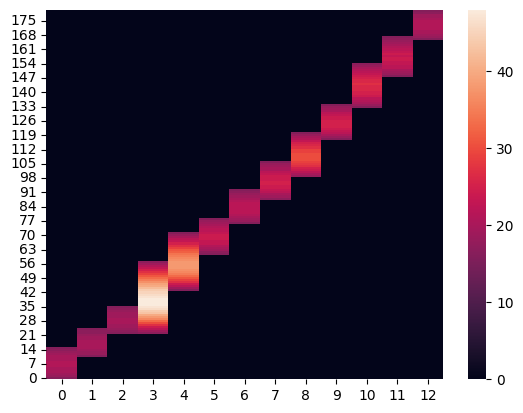

In [51]:
adc100 = l180cut[l180cut['max_intensity'] <= 100].reset_index(drop=True); print(adc100.shape)
i = 0
row = adc100.sample(n=1)
event = Event(row.iloc[i]['file_path'], row.iloc[i]['event_index'])
sns.heatmap(row.iloc[i]['image_intensity'].T)
plt.gca().invert_yaxis()

In [52]:
adc100cut = l180cut[l180cut['max_intensity'] >= 100].reset_index(drop=True); print(adc100cut.shape)


(12037, 31)


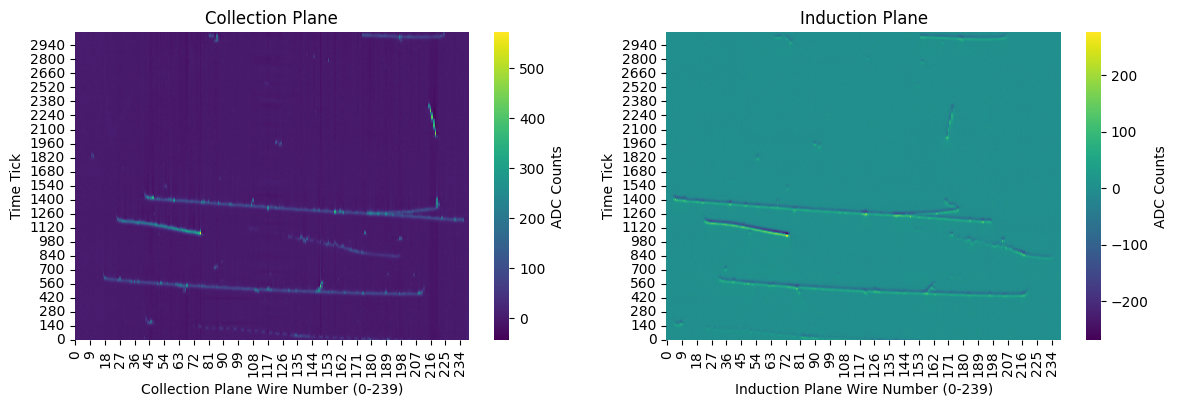

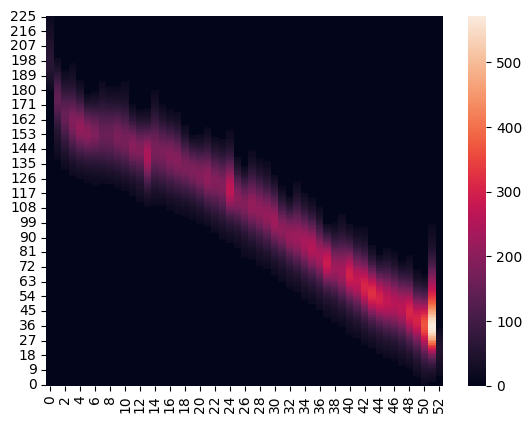

In [53]:
i = 0
row = adc100cut.sample(n=1)
event = Event(row.iloc[i]['file_path'], row.iloc[i]['event_index'])
sns.heatmap(row.iloc[i]['image_intensity'].T)
plt.gca().invert_yaxis()

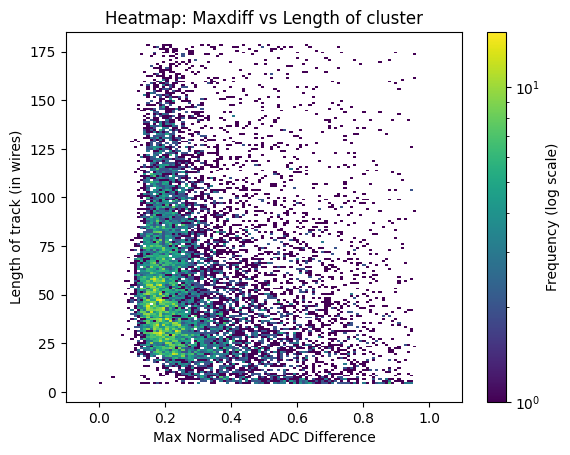

In [54]:
from matplotlib.colors import LogNorm

plt.figure()
h = plt.hist2d(adc100cut['maxdiff'], adc100cut['lengths'], bins=[100, 176], norm=LogNorm(), cmap='viridis')
plt.xlabel('Max Normalised ADC Difference')
plt.ylabel('Length of track (in wires)')
plt.ylim(-5, 185)
plt.xlim(-0.1,1.1)
plt.title('Heatmap: Maxdiff vs Length of cluster')
plt.colorbar(label='Frequency (log scale)')
plt.show()


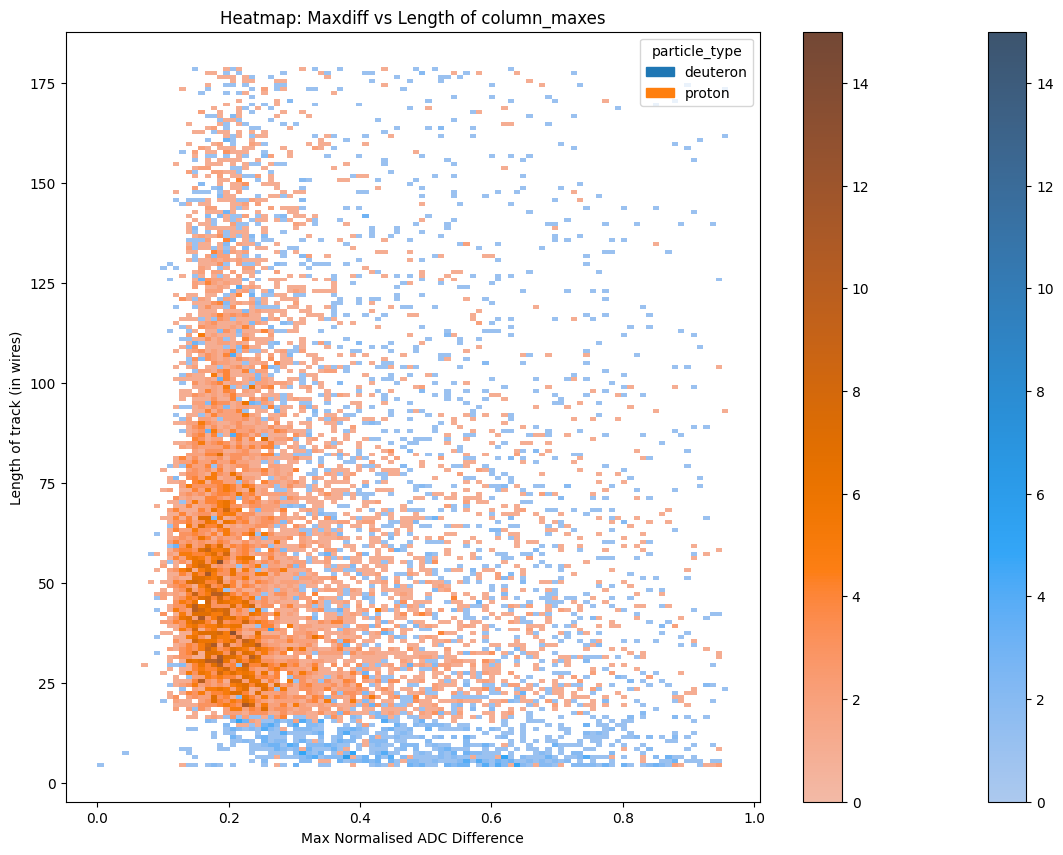

In [55]:
plt.figure(figsize=(14, 10))
sns.histplot(data=adc100cut, x='maxdiff', y='lengths', hue='particle_type', bins=[100, 176], cbar=True)
plt.xlabel('Max Normalised ADC Difference')
plt.ylabel('Length of track (in wires)')
plt.title('Heatmap: Maxdiff vs Length of column_maxes')
plt.show()

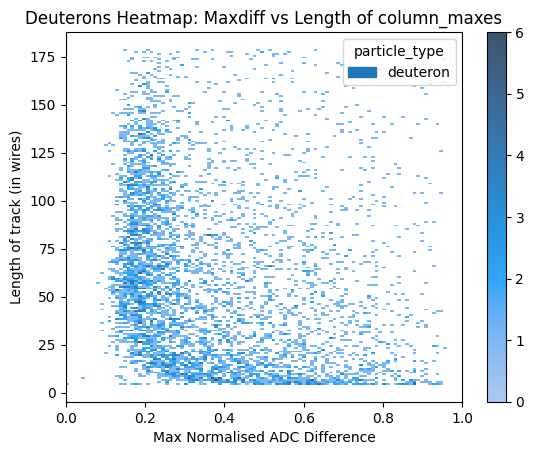

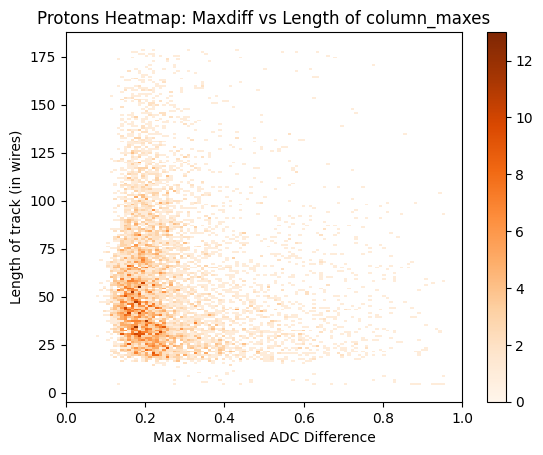

In [56]:
d = adc100cut[adc100cut['particle_type'] == 'deuteron']

plt.figure()
sns.histplot(data=d, x='maxdiff', y='lengths', hue='particle_type', bins=[100, 176], cbar=True)
plt.xlabel('Max Normalised ADC Difference')
plt.ylabel('Length of track (in wires)')
plt.xlim(0, 1)
plt.title('Deuterons Heatmap: Maxdiff vs Length of column_maxes')
plt.show()

p = adc100cut[adc100cut['particle_type'] == 'proton']

plt.figure()
sns.histplot(data=p, x='maxdiff', y='lengths', bins=[100, 176], cbar=True, cmap='Oranges')
plt.xlabel('Max Normalised ADC Difference')
plt.ylabel('Length of track (in wires)')
plt.xlim(0, 1)
plt.title('Protons Heatmap: Maxdiff vs Length of column_maxes')
plt.show()

[]

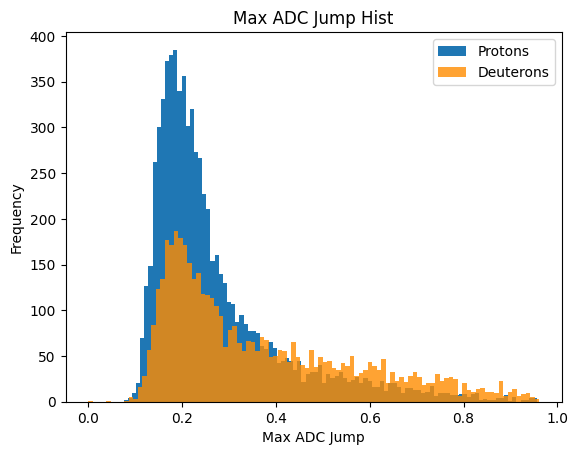

In [57]:
plt.hist(p['maxdiff'], bins=100, alpha=1, label='Protons')
plt.hist(d['maxdiff'], bins=100, alpha=0.8, color='darkorange', label='Deuterons')
plt.title('Max ADC Jump Hist'); plt.xlabel('Max ADC Jump'); plt.ylabel('Frequency'); plt.legend()
plt.plot()

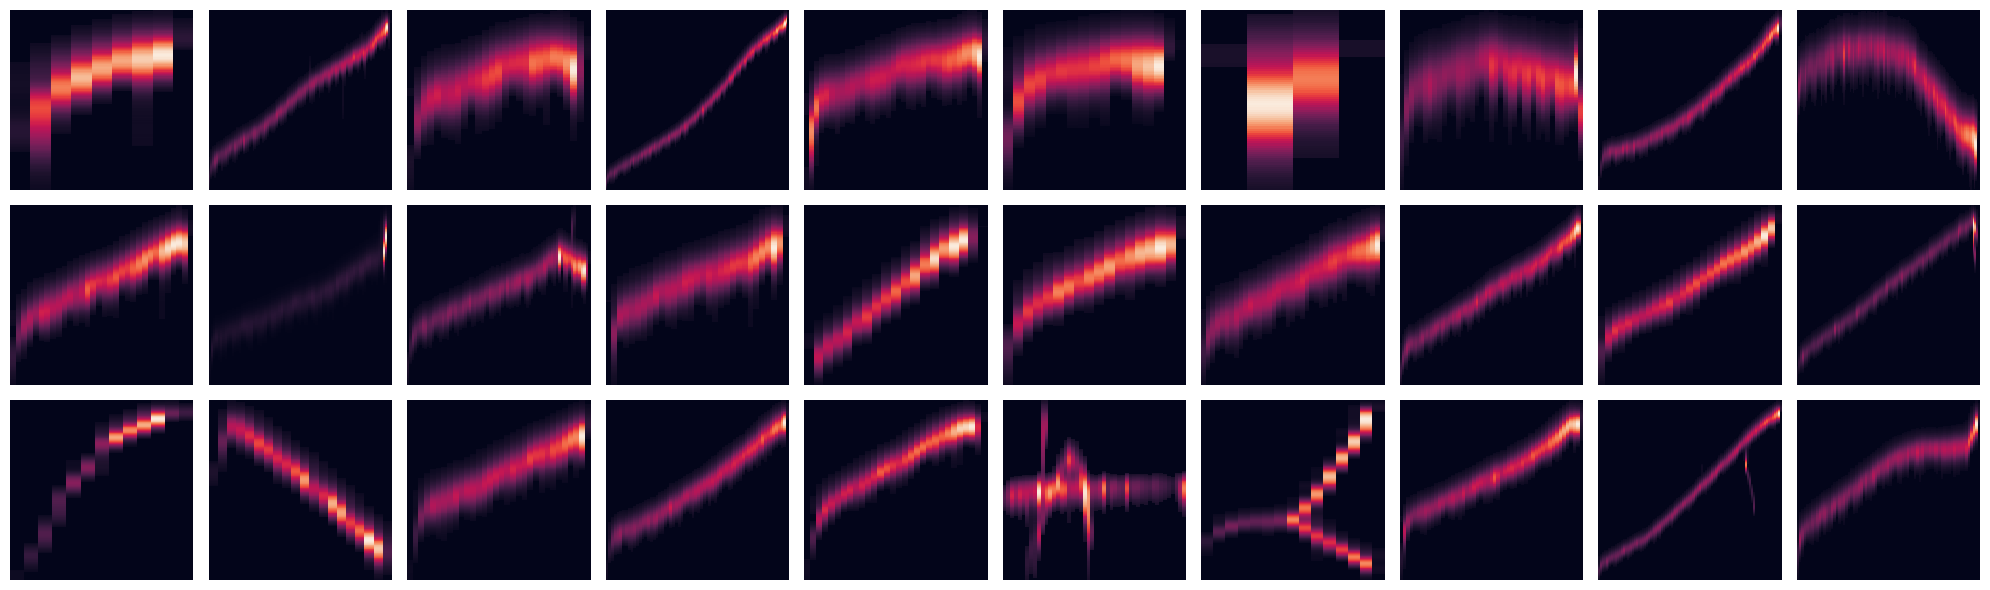

In [58]:
samples = adc100cut.sample(n=30)
n = 10  # grid size (change as needed)
fig, axes = plt.subplots(3, n, figsize=(20, 6))
for idx, ax in enumerate(axes.flat):
    if idx >= len(samples):
        break
    sns.heatmap(samples.iloc[idx]['image_intensity'].T, ax=ax, cbar=False)
    ax.axis('off')
plt.tight_layout()
plt.show()

# Toy dE/dx vs Residual Range Plots

In [86]:
# Calculate dE/dx and residual range for adc100cut data
sumADC = [np.sum(cluster, axis=1)[:-1] for cluster in adc100cut['image_intensity'].values]
adc100cut = adc100cut.copy()
adc100cut['energy'] = sumADC
residual_range = [list(range(len(cluster)-1, -1, -1)) for cluster in adc100cut['energy'].values]
adc100cut['rr'] = residual_range

e_diff = [np.diff(np.sum(cluster, axis=1)[:-1]) for cluster in adc100cut['image_intensity'].values]
adc100cut['e_diff'] = e_diff
rr_diff = [list(range(len(cluster)-1, -1, -1)) for cluster in adc100cut['e_diff'].values]
adc100cut['rr_diff'] = rr_diff



# Filter for collection plane only
coll = adc100cut[adc100cut['plane'] == 'collection']
protons = coll[(coll['particle_type'] == 'proton') & 
               (coll['bbox_min_row'] > 11) & (coll['bbox_min_row'] < 35) & 
               (coll['bbox_max_col'] > 786) & (coll['bbox_max_col'] < 1794)]
deuterons = coll[(coll['particle_type'] == 'deuteron') & 
                 (coll['bbox_min_row'] > 11) & (coll['bbox_min_row'] < 35) & 
                 (coll['bbox_max_col'] > 786) & (coll['bbox_max_col'] < 1794)]

print(f"Collection plane: {len(coll)} events")
print(f"Protons: {len(protons)} events")
print(f"Deuterons: {len(deuterons)} events")

Collection plane: 12037 events
Protons: 7322 events
Deuterons: 4715 events


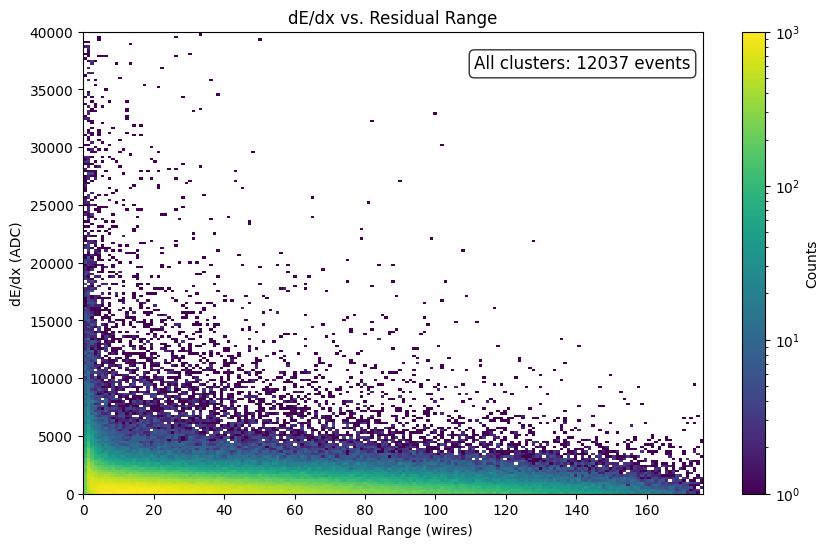

In [90]:
# Concatenate all collection plane data
rr_all = np.concatenate(coll['rr_diff'].values)
energy_all = np.concatenate(coll['e_diff'].values)

# Plot for all collection plane data
plt.figure(figsize=(10, 6))
plt.hist2d(rr_all, energy_all, bins=(177, 2000), cmap='viridis', norm=LogNorm(), cmin=1)
plt.colorbar(label='Counts')
plt.xlabel('Residual Range (wires)')
plt.ylabel('dE/dx (ADC)')
plt.ylim(0, 40000)
plt.title('dE/dx vs. Residual Range')
plt.text(0.98, 0.95, f'All clusters: {len(coll)} events', 
         transform=plt.gca().transAxes, fontsize=12, ha='right', va='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.show()

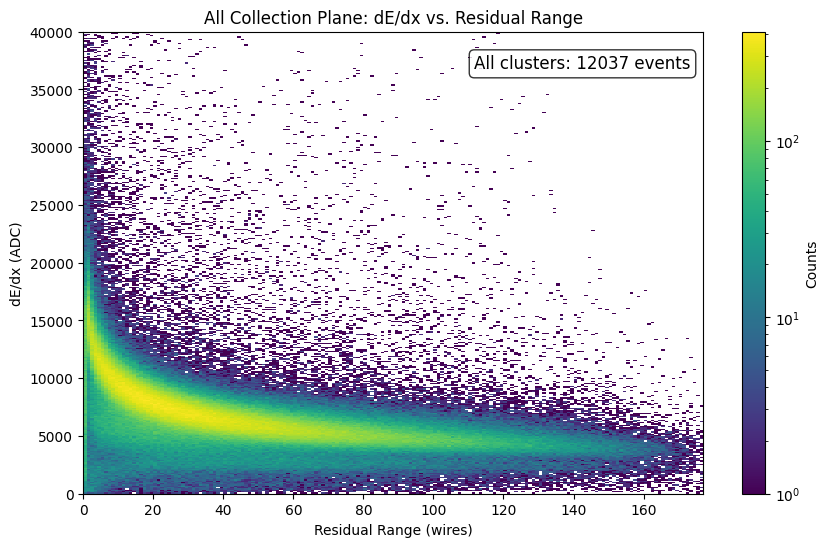

In [89]:
# Concatenate all collection plane data
rr_all = np.concatenate(coll['rr'].values)
energy_all = np.concatenate(coll['energy'].values)

# Plot for all collection plane data
plt.figure(figsize=(10, 6))
plt.hist2d(rr_all, energy_all, bins=(177, 2000), cmap='viridis', norm=LogNorm(), cmin=1)
plt.colorbar(label='Counts')
plt.xlabel('Residual Range (wires)')
plt.ylabel('dE/dx (ADC)')
plt.ylim(0, 40000)
plt.title('All Collection Plane: dE/dx vs. Residual Range')
plt.text(0.98, 0.95, f'All clusters: {len(coll)} events', 
         transform=plt.gca().transAxes, fontsize=12, ha='right', va='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.show()

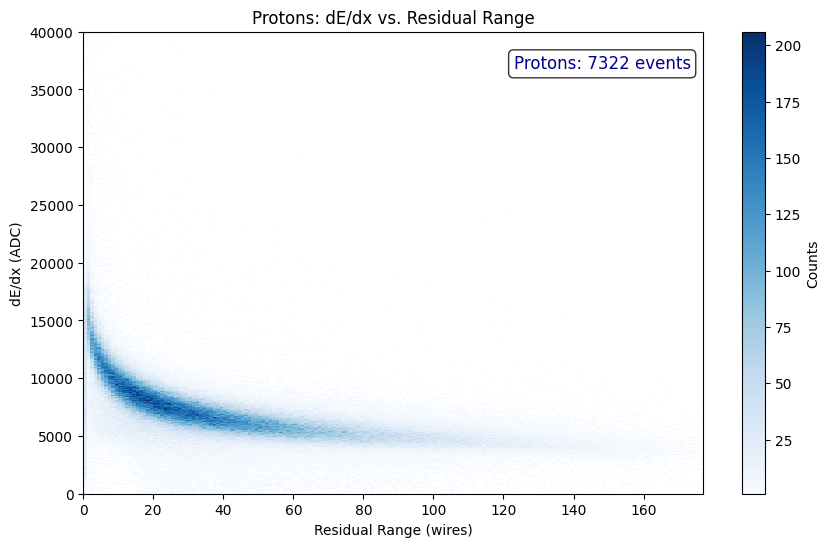

In [61]:
# Concatenate proton data
rr_protons = np.concatenate(protons['rr'].values)
energy_protons = np.concatenate(protons['energy'].values)

# Plot for protons
plt.figure(figsize=(10, 6))
plt.hist2d(rr_protons, energy_protons, bins=(177, 2000), cmap='Blues', cmin=1)
plt.colorbar(label='Counts')
plt.xlabel('Residual Range (wires)')
plt.ylabel('dE/dx (ADC)')
plt.ylim(0, 40000)
plt.title('Protons: dE/dx vs. Residual Range')
plt.text(0.98, 0.95, f'Protons: {len(protons)} events', 
         transform=plt.gca().transAxes, fontsize=12, color='darkblue',
         ha='right', va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.show()

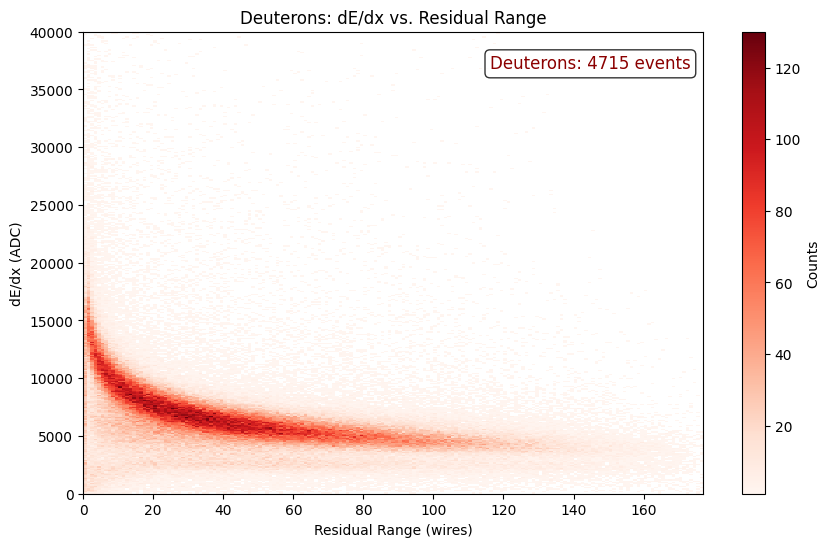

In [62]:
# Concatenate deuteron data
rr_deuterons = np.concatenate(deuterons['rr'].values)
energy_deuterons = np.concatenate(deuterons['energy'].values)

# Plot for deuterons
plt.figure(figsize=(10, 6))
plt.hist2d(rr_deuterons, energy_deuterons, bins=(177, 2000), cmap='Reds', cmin=1)
plt.colorbar(label='Counts')
plt.xlabel('Residual Range (wires)')
plt.ylabel('dE/dx (ADC)')
plt.ylim(0, 40000)
plt.title('Deuterons: dE/dx vs. Residual Range')
plt.text(0.98, 0.95, f'Deuterons: {len(deuterons)} events', 
         transform=plt.gca().transAxes, fontsize=12, color='darkred',
         ha='right', va='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.show()

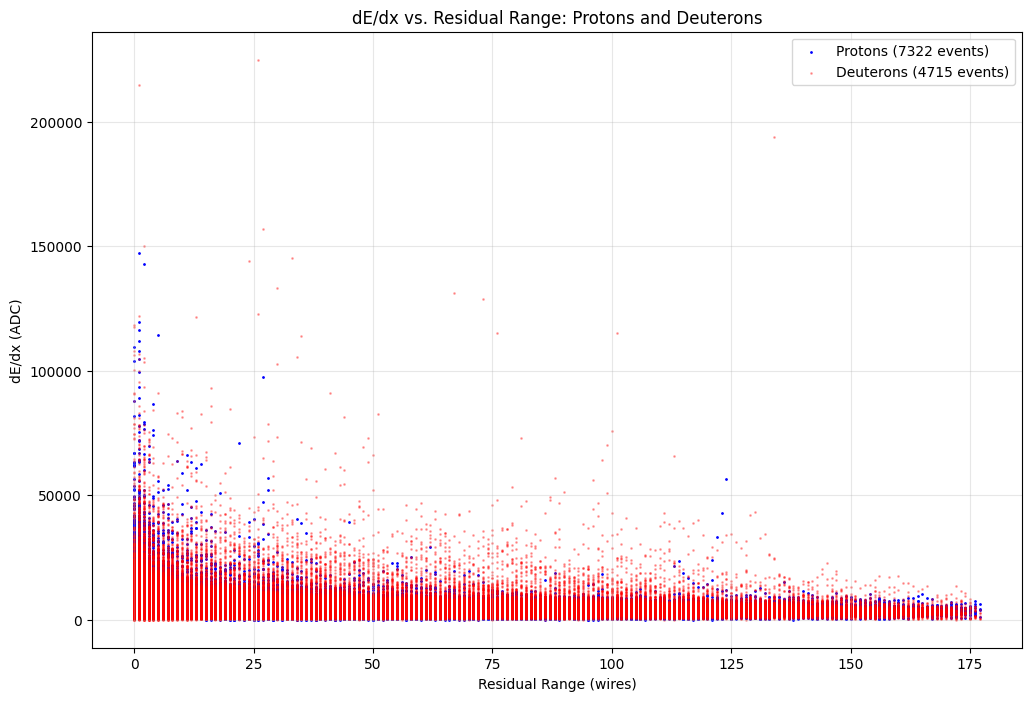

In [63]:
# Scatter plot with deuterons and protons colored differently
plt.figure(figsize=(12, 8))

# Plot protons
plt.scatter(rr_protons, energy_protons, c='blue', alpha=1, s=1, label=f'Protons ({len(protons)} events)')

# Plot deuterons  
plt.scatter(rr_deuterons, energy_deuterons, c='red', alpha=0.3, s=1, label=f'Deuterons ({len(deuterons)} events)')

plt.xlabel('Residual Range (wires)')
plt.ylabel('dE/dx (ADC)')
plt.title('dE/dx vs. Residual Range: Protons and Deuterons')
plt.legend()
# plt.ylim(0, 40000)
plt.grid(True, alpha=0.3)
plt.show()

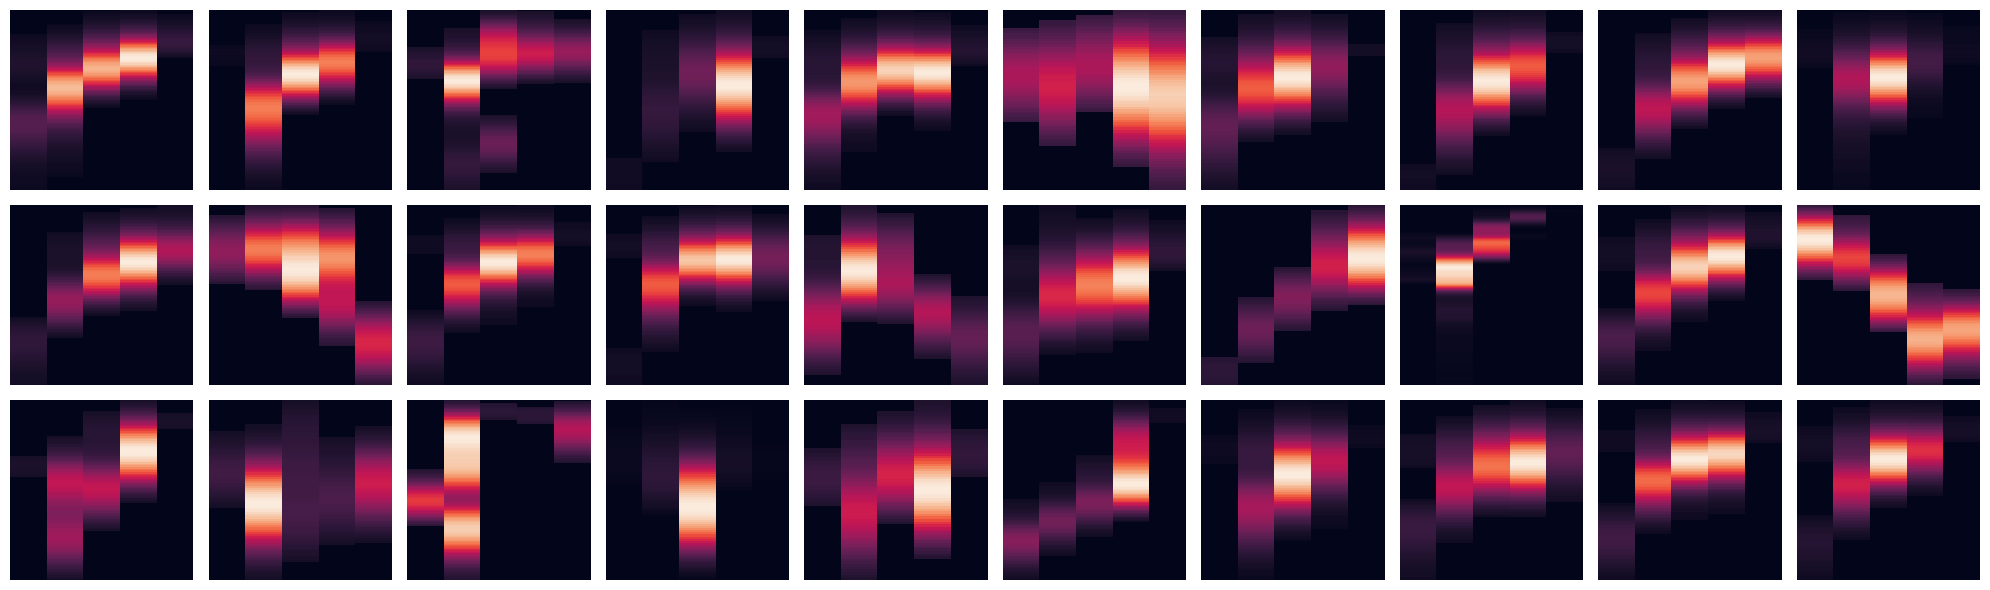

In [64]:
l5 = adc100cut[adc100cut['lengths'] == 5]
samples = l5.sample(n=30)
n = 10  # grid size (change as needed)
fig, axes = plt.subplots(3, n, figsize=(20, 6))
for idx, ax in enumerate(axes.flat):
    if idx >= len(samples):
        break
    sns.heatmap(samples.iloc[idx]['image_intensity'].T, ax=ax, cbar=False)
    ax.axis('off')
plt.tight_layout()
plt.show()

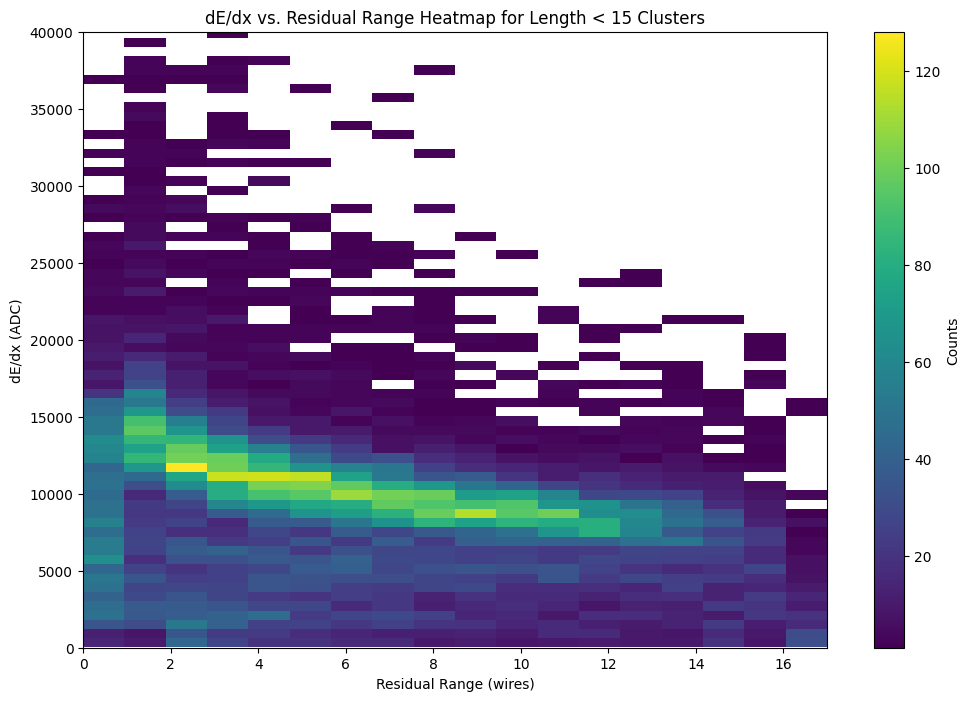

L5 Collection plane: 1402 events
L5 Protons: 327 events
L5 Deuterons: 1075 events


In [154]:
# Plot dE/dx from l5 data (length 15 clusters)
l5 = adc100cut[adc100cut['lengths'] < 20].reset_index(drop=True) # change back to 15

# Calculate dE/dx for l5
sumADC_l5 = [np.sum(cluster, axis=1)[:-1] for cluster in l5['image_intensity'].values]
l5['energy'] = sumADC_l5
residual_range_l5 = [list(range(len(cluster)-1, -1, -1)) for cluster in l5['energy'].values]
l5['rr'] = residual_range_l5

# Filter for collection plane
l5_coll = l5[l5['plane'] == 'collection']
l5_protons = l5_coll[l5_coll['particle_type'] == 'proton']
l5_deuterons = l5_coll[l5_coll['particle_type'] == 'deuteron']

# Concatenate data
rr_l5_protons = np.concatenate(l5_protons['rr'].values) if len(l5_protons) > 0 else np.array([])
energy_l5_protons = np.concatenate(l5_protons['energy'].values) if len(l5_protons) > 0 else np.array([])
rr_l5_deuterons = np.concatenate(l5_deuterons['rr'].values) if len(l5_deuterons) > 0 else np.array([])
energy_l5_deuterons = np.concatenate(l5_deuterons['energy'].values) if len(l5_deuterons) > 0 else np.array([])

# Heatmap for l5 data
rr_l5_all = np.concatenate([rr_l5_protons, rr_l5_deuterons]) if len(rr_l5_protons) > 0 or len(rr_l5_deuterons) > 0 else np.array([])
energy_l5_all = np.concatenate([energy_l5_protons, energy_l5_deuterons]) if len(energy_l5_protons) > 0 or len(energy_l5_deuterons) > 0 else np.array([])

plt.figure(figsize=(12, 8))

if len(rr_l5_all) > 0:
    plt.hist2d(rr_l5_all, energy_l5_all, bins=(18, 250), cmap='viridis', cmin=1)
    plt.colorbar(label='Counts')
    
plt.xlabel('Residual Range (wires)')
plt.ylabel('dE/dx (ADC)')
plt.ylim(0, 40000)
plt.title('dE/dx vs. Residual Range Heatmap for Length < 15 Clusters')
plt.show()

print(f"L5 Collection plane: {len(l5_coll)} events")
print(f"L5 Protons: {len(l5_protons)} events") 
print(f"L5 Deuterons: {len(l5_deuterons)} events")

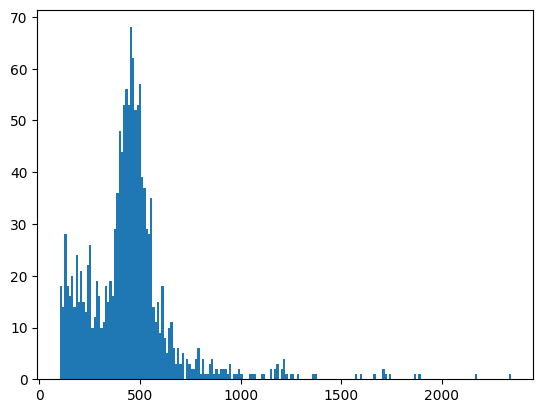

In [155]:
%matplotlib inline
plt.hist(l5['max_intensity'], bins=200); plt.show()

In [156]:
max200 = l5[l5['max_intensity'] > 200]; max200.shape

(1236, 35)

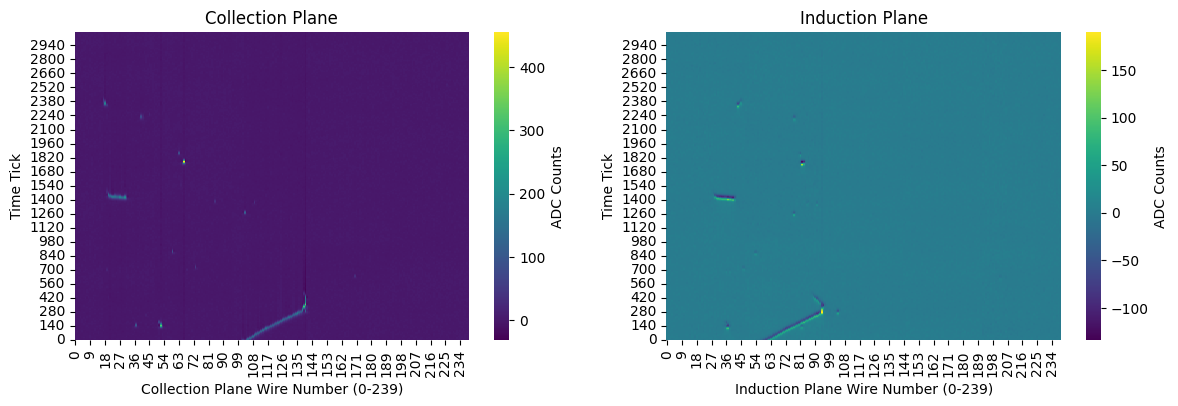

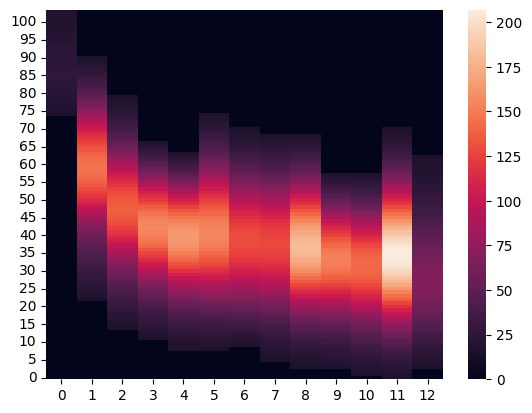

In [157]:
i = 0
row = max200.sample(n=1)
event = Event(row.iloc[i]['file_path'], row.iloc[i]['event_index'])
sns.heatmap(row.iloc[i]['image_intensity'].T)
plt.gca().invert_yaxis()

In [158]:
sumADC = [np.sum(cluster, axis=1)[:-1] for cluster in max200['image_intensity'].values]
max200 = max200.copy()
max200['energy'] = sumADC

residual_range = [list(range(len(cluster)-1, -1, -1)) for cluster in max200['energy'].values]
max200['rr'] = residual_range

rr_deuterons = np.concatenate(max200['rr'].values)
energy_deuterons = np.concatenate(max200['energy'].values)

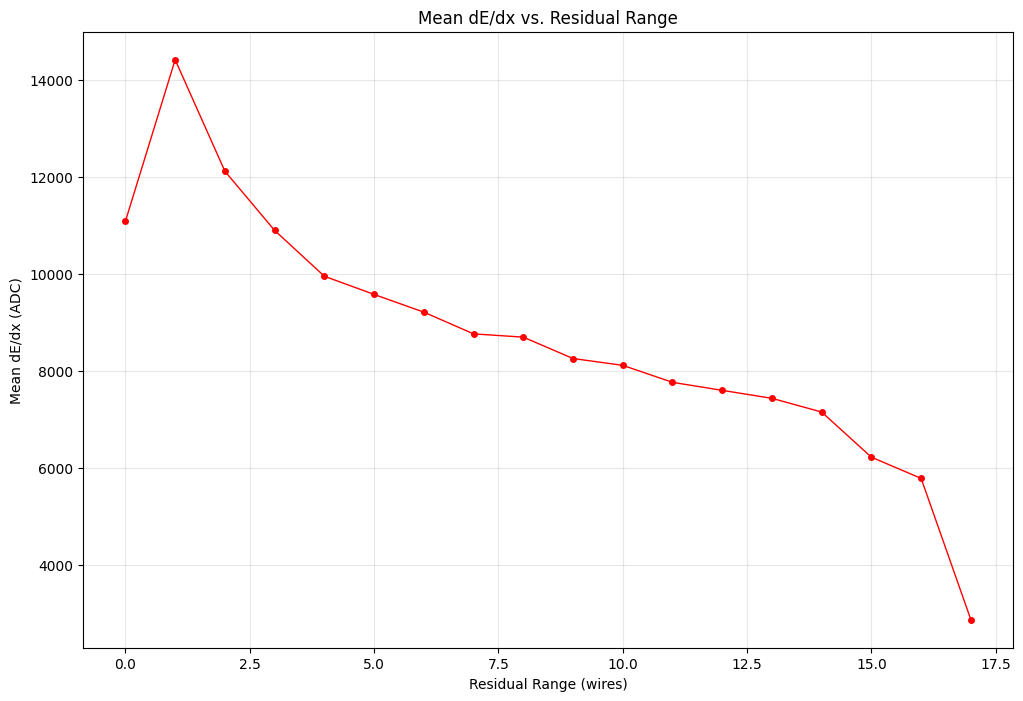

Total number of rr values: 18
Range of rr values: 0 to 17
Range of mean energy values: 2870.54 to 14419.25


In [159]:
rr_energy_df = pd.DataFrame({
    'rr': rr_deuterons,
    'energy': energy_deuterons
})

mean_energy_by_rr = rr_energy_df.groupby('rr')['energy'].mean().reset_index()

plt.figure(figsize=(12, 8))
plt.plot(mean_energy_by_rr['rr'], mean_energy_by_rr['energy'], 'o-', markersize=4, linewidth=1, color='r')
plt.xlabel('Residual Range (wires)')
plt.ylabel('Mean dE/dx (ADC)')
plt.title('Mean dE/dx vs. Residual Range')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Total number of rr values: {len(mean_energy_by_rr)}")
print(f"Range of rr values: {mean_energy_by_rr['rr'].min()} to {mean_energy_by_rr['rr'].max()}")
print(f"Range of mean energy values: {mean_energy_by_rr['energy'].min():.2f} to {mean_energy_by_rr['energy'].max():.2f}")

In [160]:
p15 = protons[(protons['lengths'] < 30) & (protons['max_intensity'] > 200)]; p15.shape

(1411, 35)

In [161]:
sumADC = [np.sum(cluster, axis=1)[:-1] for cluster in p15['image_intensity'].values]
p15 = p15.copy()
p15['energy'] = sumADC

residual_range = [list(range(len(cluster)-1, -1, -1)) for cluster in p15['energy'].values]
p15['rr'] = residual_range

rr_protons = np.concatenate(p15['rr'].values)
energy_protons = np.concatenate(p15['energy'].values)

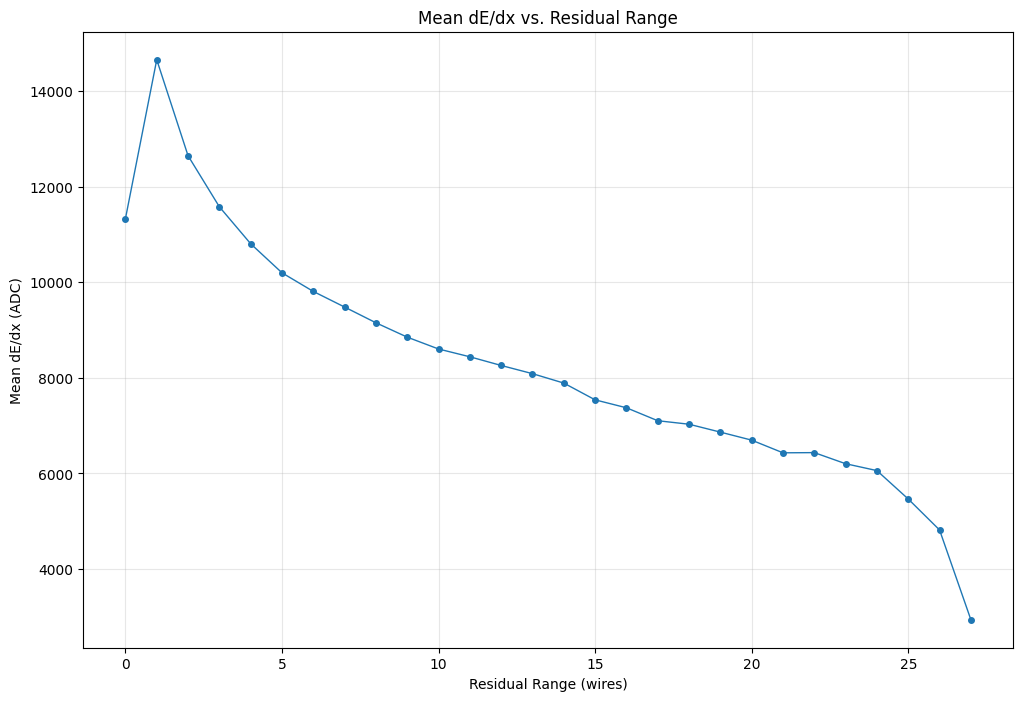

Total number of rr values: 28
Range of rr values: 0 to 27
Range of mean energy values: 2937.19 to 14660.48


In [162]:
rr_energy_df_protons = pd.DataFrame({
    'rr': rr_protons,
    'energy': energy_protons
})

mean_energy_by_rr_protons = rr_energy_df_protons.groupby('rr')['energy'].mean().reset_index()

plt.figure(figsize=(12, 8))
plt.plot(mean_energy_by_rr_protons['rr'], mean_energy_by_rr_protons['energy'], 'o-', markersize=4, linewidth=1)
plt.xlabel('Residual Range (wires)')
plt.ylabel('Mean dE/dx (ADC)')
plt.title('Mean dE/dx vs. Residual Range')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Total number of rr values: {len(mean_energy_by_rr_protons)}")
print(f"Range of rr values: {mean_energy_by_rr_protons['rr'].min()} to {mean_energy_by_rr_protons['rr'].max()}")
print(f"Range of mean energy values: {mean_energy_by_rr_protons['energy'].min():.2f} to {mean_energy_by_rr_protons['energy'].max():.2f}")

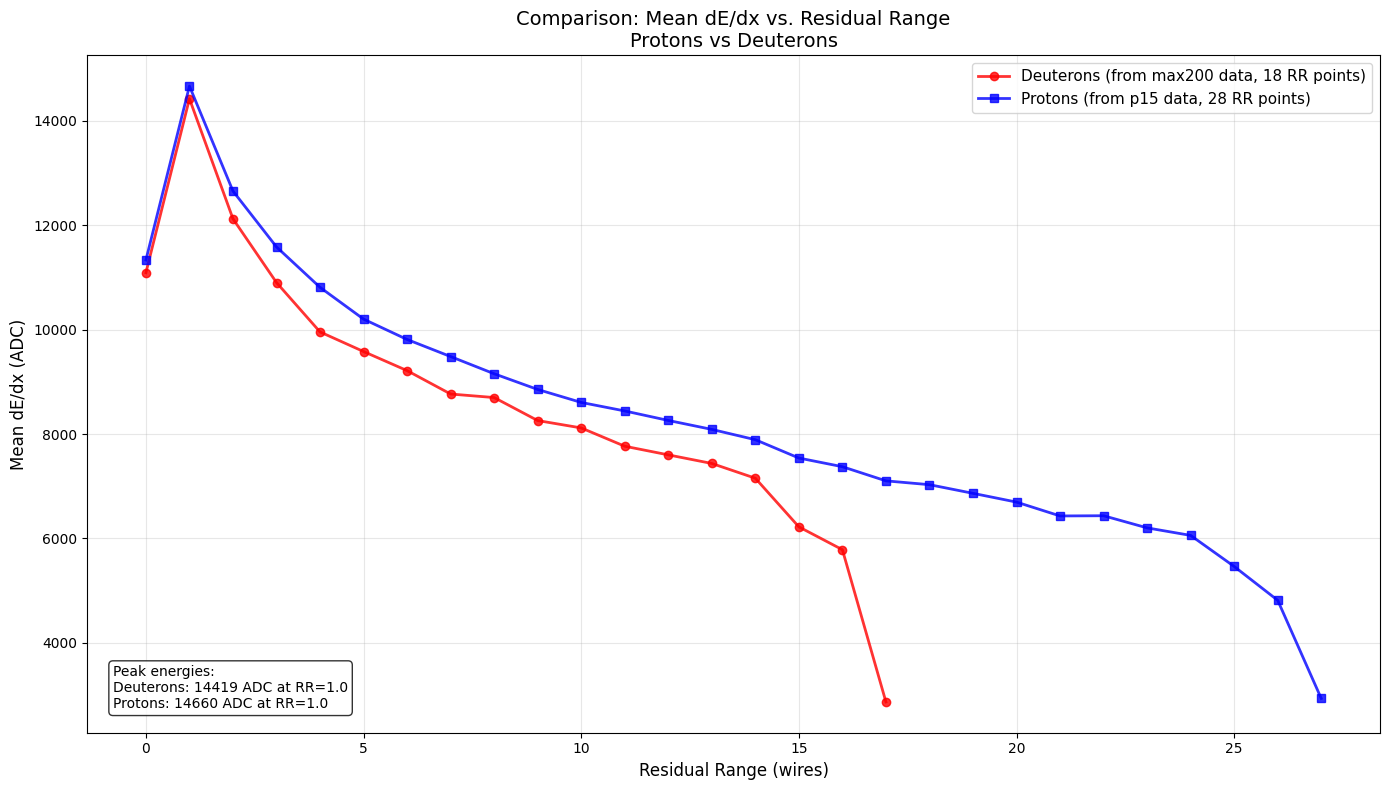

Comparison Summary:
Deuterons - RR range: 0 to 17
Deuterons - Energy range: 2871 to 14419 ADC
Protons - RR range: 0 to 27
Protons - Energy range: 2937 to 14660 ADC


In [163]:
# Combined plot: Protons vs Deuterons Mean Energy vs Residual Range
plt.figure(figsize=(14, 8))

# Plot deuterons (from max200 data)
plt.plot(mean_energy_by_rr['rr'], mean_energy_by_rr['energy'], 
         'o-', markersize=6, linewidth=2, color='red', 
         label=f'Deuterons (from max200 data, {len(mean_energy_by_rr)} RR points)', alpha=0.8)

# Plot protons (from p15 data)
plt.plot(mean_energy_by_rr_protons['rr'], mean_energy_by_rr_protons['energy'], 
         's-', markersize=6, linewidth=2, color='blue', 
         label=f'Protons (from p15 data, {len(mean_energy_by_rr_protons)} RR points)', alpha=0.8)

plt.xlabel('Residual Range (wires)', fontsize=12)
plt.ylabel('Mean dE/dx (ADC)', fontsize=12)
plt.title('Comparison: Mean dE/dx vs. Residual Range\nProtons vs Deuterons', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)

# Add some statistics as text
deuteron_peak = mean_energy_by_rr.loc[mean_energy_by_rr['energy'].idxmax()]
proton_peak = mean_energy_by_rr_protons.loc[mean_energy_by_rr_protons['energy'].idxmax()]

plt.text(0.02, 0.1, 
         f'Peak energies:\n' +
         f'Deuterons: {deuteron_peak["energy"]:.0f} ADC at RR={deuteron_peak["rr"]}\n' +
         f'Protons: {proton_peak["energy"]:.0f} ADC at RR={proton_peak["rr"]}',
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print("Comparison Summary:")
print(f"Deuterons - RR range: {mean_energy_by_rr['rr'].min()} to {mean_energy_by_rr['rr'].max()}")
print(f"Deuterons - Energy range: {mean_energy_by_rr['energy'].min():.0f} to {mean_energy_by_rr['energy'].max():.0f} ADC")
print(f"Protons - RR range: {mean_energy_by_rr_protons['rr'].min()} to {mean_energy_by_rr_protons['rr'].max()}")
print(f"Protons - Energy range: {mean_energy_by_rr_protons['energy'].min():.0f} to {mean_energy_by_rr_protons['energy'].max():.0f} ADC")

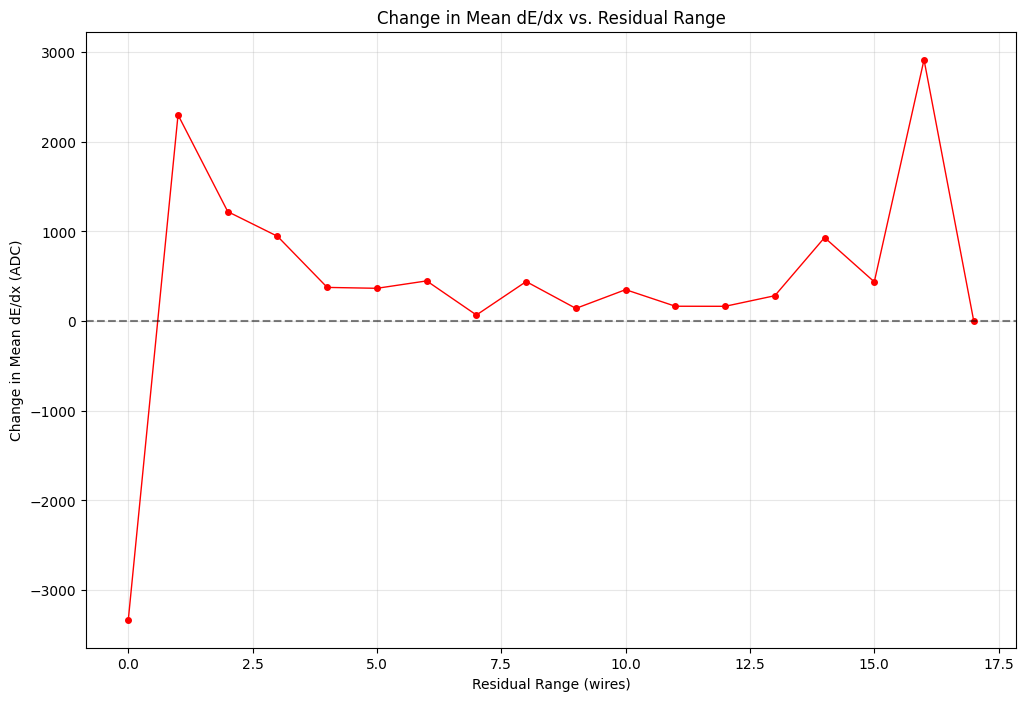

Total number of rr values: 18
Range of rr values: 0 to 17
Range of energy differences: -3330.78 to 2914.59


In [164]:
rr_energy_df = pd.DataFrame({
    'rr': rr_deuterons,
    'energy': energy_deuterons
})

mean_energy_by_rr = rr_energy_df.groupby('rr')['energy'].mean().reset_index()

# Sort by rr in descending order to calculate differences correctly
mean_energy_by_rr = mean_energy_by_rr.sort_values('rr', ascending=False).reset_index(drop=True)

# Calculate differences: higher_rr - lower_rr (e.g., 12-11, 11-10, etc.)
energy_diff = np.diff(mean_energy_by_rr['energy'])
# Add 0 as the first value (for the highest RR point)
energy_diff = np.concatenate([[0], energy_diff])

# Sort back to ascending order for plotting
mean_energy_by_rr = mean_energy_by_rr.sort_values('rr', ascending=True).reset_index(drop=True)
energy_diff = energy_diff[::-1]  # Reverse to match ascending RR order

plt.figure(figsize=(12, 8))
plt.plot(mean_energy_by_rr['rr'], energy_diff, 'o-', markersize=4, linewidth=1, color='r')
plt.xlabel('Residual Range (wires)')
plt.ylabel('Change in Mean dE/dx (ADC)')
plt.title('Change in Mean dE/dx vs. Residual Range')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.show()

print(f"Total number of rr values: {len(mean_energy_by_rr)}")
print(f"Range of rr values: {mean_energy_by_rr['rr'].min()} to {mean_energy_by_rr['rr'].max()}")
print(f"Range of energy differences: {energy_diff.min():.2f} to {energy_diff.max():.2f}")

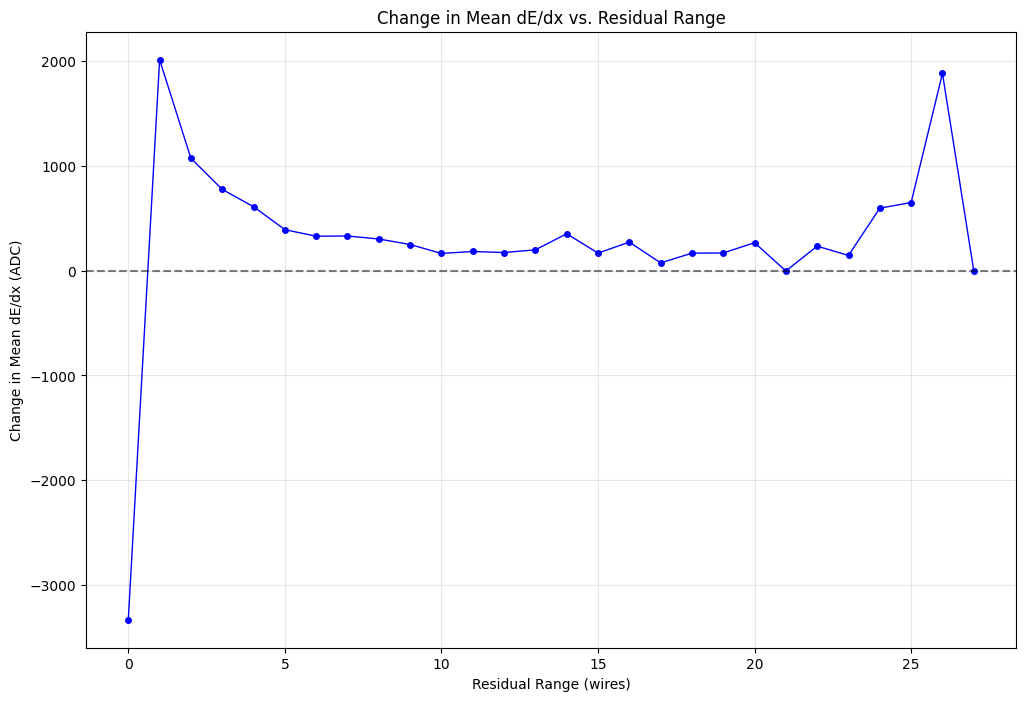

Total number of rr values: 28
Range of rr values: 0 to 27
Range of energy differences: -3328.56 to 2009.64


In [165]:
rr_energy_df = pd.DataFrame({
    'rr': rr_protons,
    'energy': energy_protons
})

mean_energy_by_rr = rr_energy_df.groupby('rr')['energy'].mean().reset_index()

# Sort by rr in descending order to calculate differences correctly
mean_energy_by_rr = mean_energy_by_rr.sort_values('rr', ascending=False).reset_index(drop=True)

# Calculate differences: higher_rr - lower_rr (e.g., 12-11, 11-10, etc.)
energy_diff = np.diff(mean_energy_by_rr['energy'])
# Add 0 as the first value (for the highest RR point)
energy_diff = np.concatenate([[0], energy_diff])

# Sort back to ascending order for plotting
mean_energy_by_rr = mean_energy_by_rr.sort_values('rr', ascending=True).reset_index(drop=True)
energy_diff = energy_diff[::-1]  # Reverse to match ascending RR order

plt.figure(figsize=(12, 8))
plt.plot(mean_energy_by_rr['rr'], energy_diff, 'o-', markersize=4, linewidth=1, color='b')
plt.xlabel('Residual Range (wires)')
plt.ylabel('Change in Mean dE/dx (ADC)')
plt.title('Change in Mean dE/dx vs. Residual Range')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.show()

print(f"Total number of rr values: {len(mean_energy_by_rr)}")
print(f"Range of rr values: {mean_energy_by_rr['rr'].min()} to {mean_energy_by_rr['rr'].max()}")
print(f"Range of energy differences: {energy_diff.min():.2f} to {energy_diff.max():.2f}")

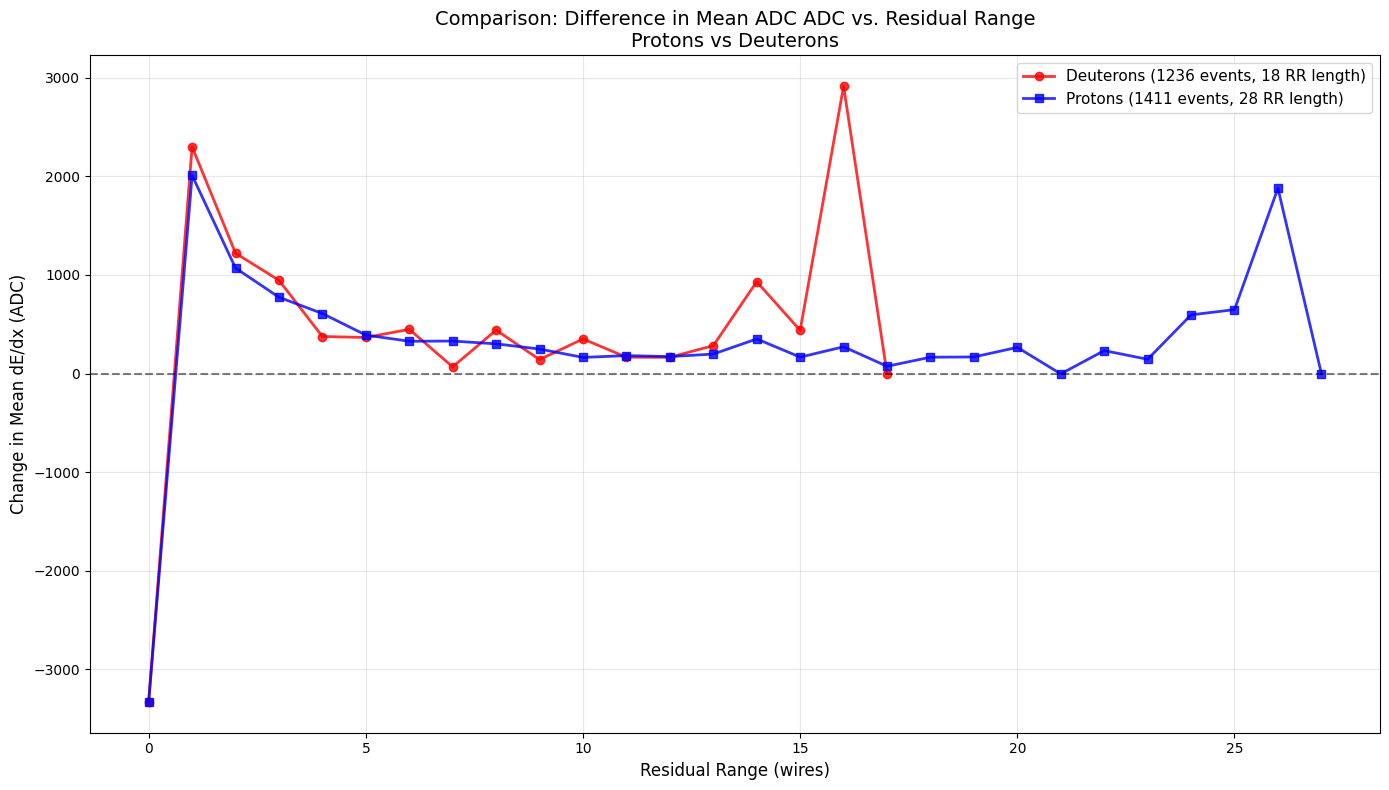

Comparison Summary:
Deuterons - Total events: 1236, Total RR values: 18
Deuterons - Energy difference range: -3330.78 to 2914.59
Protons - Total events: 1411, Total RR values: 28
Protons - Energy difference range: -3328.56 to 2009.64


In [168]:
# Calculate differences for deuterons
rr_energy_df_deuterons = pd.DataFrame({
    'rr': rr_deuterons,
    'energy': energy_deuterons
})

mean_energy_by_rr_deuterons = rr_energy_df_deuterons.groupby('rr')['energy'].mean().reset_index()

# Sort by rr in descending order to calculate differences correctly
mean_energy_by_rr_deuterons = mean_energy_by_rr_deuterons.sort_values('rr', ascending=False).reset_index(drop=True)

# Calculate differences: higher_rr - lower_rr (e.g., 12-11, 11-10, etc.)
energy_diff_deuterons = np.diff(mean_energy_by_rr_deuterons['energy'])
# Add 0 as the first value (for the highest RR point)
energy_diff_deuterons = np.concatenate([[0], energy_diff_deuterons])

# Sort back to ascending order for plotting
mean_energy_by_rr_deuterons = mean_energy_by_rr_deuterons.sort_values('rr', ascending=True).reset_index(drop=True)
energy_diff_deuterons = energy_diff_deuterons[::-1]  # Reverse to match ascending RR order

# Calculate differences for protons
rr_energy_df_protons = pd.DataFrame({
    'rr': rr_protons,
    'energy': energy_protons
})

mean_energy_by_rr_protons = rr_energy_df_protons.groupby('rr')['energy'].mean().reset_index()

# Sort by rr in descending order to calculate differences correctly
mean_energy_by_rr_protons = mean_energy_by_rr_protons.sort_values('rr', ascending=False).reset_index(drop=True)

# Calculate differences: higher_rr - lower_rr (e.g., 12-11, 11-10, etc.)
energy_diff_protons = np.diff(mean_energy_by_rr_protons['energy'])
# Add 0 as the first value (for the highest RR point)
energy_diff_protons = np.concatenate([[0], energy_diff_protons])

# Sort back to ascending order for plotting
mean_energy_by_rr_protons = mean_energy_by_rr_protons.sort_values('rr', ascending=True).reset_index(drop=True)
energy_diff_protons = energy_diff_protons[::-1]  # Reverse to match ascending RR order

# Combined plot
plt.figure(figsize=(14, 8))

# Plot deuterons
plt.plot(mean_energy_by_rr_deuterons['rr'], energy_diff_deuterons, 
         'o-', markersize=6, linewidth=2, color='red', 
         label=f'Deuterons ({len(max200)} events, {len(mean_energy_by_rr_deuterons)} RR length)', alpha=0.8)

# Plot protons
plt.plot(mean_energy_by_rr_protons['rr'], energy_diff_protons, 
         's-', markersize=6, linewidth=2, color='blue', 
         label=f'Protons ({len(p15)} events, {len(mean_energy_by_rr_protons)} RR length)', alpha=0.8)

plt.xlabel('Residual Range (wires)', fontsize=12)
plt.ylabel('Change in Mean dE/dx (ADC)', fontsize=12)
plt.title('Comparison: Difference in Mean ADC ADC vs. Residual Range\nProtons vs Deuterons', fontsize=14)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
plt.legend(fontsize=11)

plt.tight_layout()
plt.show()

print("Comparison Summary:")
print(f"Deuterons - Total events: {len(max200)}, Total RR values: {len(mean_energy_by_rr_deuterons)}")
print(f"Deuterons - Energy difference range: {energy_diff_deuterons.min():.2f} to {energy_diff_deuterons.max():.2f}")
print(f"Protons - Total events: {len(p15)}, Total RR values: {len(mean_energy_by_rr_protons)}")
print(f"Protons - Energy difference range: {energy_diff_protons.min():.2f} to {energy_diff_protons.max():.2f}")

In [132]:
p15

event_idx   run  subrun  event  \
4718           3  8557      16    995   
4722           8  8557      34   1801   
4728          15  8557      52   2635   
4729          16  8557      54   2711   
4733          20  8557      62   3109   
...          ...   ...     ...    ...   
11985       7583  9787      54   5128   
11991       7589  9788      69   4963   
11995       7593  9788     117   9304   
11996       7594  9788     123   9887   
12030       7629  9788     283  24830   

                                               file_path  event_index  \
4718   /Users/user/data/research/proton-deuteron/rawp...            0   
4722   /Users/user/data/research/proton-deuteron/rawp...            0   
4728   /Users/user/data/research/proton-deuteron/rawp...            0   
4729   /Users/user/data/research/proton-deuteron/rawp...            0   
4733   /Users/user/data/research/proton-deuteron/rawp...            0   
...                                                  ...          ...   
11985  /Users/user/data/research/proton-deuteron/rawp...            0   
11991  /Users/user/data/research/proton-deuteron/rawp...            0   
11995  /Users/user/data/research/proton-deuteron/rawp...            0   
11996  /Users/user/data/research/proton-deuteron/rawp...            1   
12030  /Users/user/data/research/proton-deuteron/rawp...            0   

      particle_type       plane  cluster_idx    area  ...  \
4718         proton  collection            0  1768.0  ...   
4722         proton  collection            3  1809.0  ...   
4728         proton  collection            0  1794.0  ...   
4729         proton  collection            0  1878.0  ...   
4733         proton  collection            0  1689.0  ...   
...             ...         ...          ...     ...  ...   
11985        proton  collection            1  1663.0  ...   
11991        proton  collection            0  1237.0  ...   
11995        proton  collection            1  1353.0  ...   
11996        proton  collection            0  1639.0  ...   
12030        proton  collection            1  1752.0  ...   

                                      matrix_transformed  \
4718   [[16.0, -0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0,...   
4722   [[16.0, 0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, ...   
4728   [[16.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0....   
4729   [[16.0, 0.0, 0.0, -0.0, -0.0, 0.0, -0.0, 0.0, ...   
4733   [[17.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0....   
...                                                  ...   
11985  [[16.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0...   
11991  [[16.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, -0.0, -...   
11995  [[17.0, -0.0, -0.0, 0.0, -0.0, -0.0, 0.0, 0.0,...   
11996  [[16.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, -0.0, ...   
12030  [[16.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, 0....   

                                            column_maxes  \
4718   [203.0, 315.0, 248.0, 257.0, 261.0, 288.0, 287...   
4722   [30.0, 257.0, 246.0, 262.0, 280.0, 235.0, 245....   
4728   [30.0, 253.0, 257.0, 228.0, 257.0, 277.0, 269....   
4729   [216.0, 324.0, 250.0, 287.0, 227.0, 204.0, 222...   
4733   [157.0, 201.0, 179.0, 194.0, 162.0, 152.0, 173...   
...                                                  ...   
11985  [74.0, 129.0, 121.0, 145.0, 119.0, 127.0, 144....   
11991  [40.0, 111.0, 119.0, 117.0, 126.0, 121.0, 131....   
11995  [91.0, 109.0, 97.0, 94.0, 81.0, 96.0, 97.0, 99...   
11996  [32.0, 64.0, 93.0, 102.0, 98.0, 105.0, 105.0, ...   
12030  [58.0, 104.0, 112.0, 104.0, 126.0, 136.0, 125....   

                                              normalised  \
4718   [0.4337606837606838, 0.6730769230769231, 0.529...   
4722   [0.06564551422319474, 0.562363238512035, 0.538...   
4728   [0.055248618784530384, 0.46593001841620624, 0....   
4729   [0.3412322274881517, 0.5118483412322274, 0.394...   
4733   [0.35926773455377575, 0.459954233409611, 0.409...   
...                                                  ...   
11985  [0.25170068027210885, 0.43877551020

In [133]:
masses = pd.read_csv('/Users/user/data/research/proton-deuteron/csv/picky+match.csv')

In [134]:
l5 = pd.merge(
    l5,
    masses[['run', 'subrun', 'event', 'p', 'm', 'beamline_mass']],
    on=['run', 'subrun', 'event'],
    how='left'
)

In [135]:
l5.columns

Index(['event_idx', 'run', 'subrun', 'event', 'file_path', 'event_index',
       'particle_type', 'plane', 'cluster_idx', 'area', 'max_intensity',
       'min_intensity', 'mean_intensity', 'total_intensity', 'centroid_x',
       'centroid_y', 'bbox_min_row', 'bbox_min_col', 'bbox_max_row',
       'bbox_max_col', 'width', 'height', 'aspect_ratio', 'compactness',
       'image_intensity', 'matrix_transformed', 'column_maxes', 'normalised',
       'adcdiff', 'maxdiff', 'lengths', 'energy', 'rr', 'e_diff', 'rr_diff',
       'p', 'm', 'beamline_mass'],
      dtype='object')

In [81]:
# from matplotlib.patches import Rectangle

# for i in range(min(843, len(l5))):
    
#     row = l5.iloc[i]
#     event = Event(l5.iloc[i]['file_path'], index=l5.iloc[i]['event_index'], plot=False)
    
#     c = event.collection
#     a = event.induction

#     fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

#     sns.heatmap(c.T, cmap="viridis", cbar_kws={'label': 'ADC Counts'}, ax=ax1)
#     ax1.set_xlabel("Collection Plane Wire Number (0-239)")
#     ax1.set_ylabel("Time Tick")
#     ax1.set_title(f"Collection Plane - Beamline Mass: {row['beamline_mass']:.2f}")
#     ax1.invert_yaxis()

#     start_wire = row['bbox_min_row'] 
#     start_time = row['bbox_min_col']
#     width = row['height']
#     height = row['width']
    
#     rect = Rectangle((start_wire, start_time), 
#                      width, height, 
#                      linewidth=1, 
#                      edgecolor='red', 
#                      facecolor='none')
#     ax1.add_patch(rect)

#     sns.heatmap(a.T, cmap='viridis', cbar_kws={'label': 'ADC Counts'}, ax=ax2)
#     ax2.set_xlabel("Induction Plane Wire Number (0-239)")
#     ax2.set_ylabel("Time Tick")
#     ax2.set_title("Induction Plane")
#     ax2.invert_yaxis()
    
#     plt.tight_layout()  
#     # plt.savefig(f'/Users/user/data/research/proton-deuteron/findingdeuterons/{i}.png', 
#     #             dpi=150, bbox_inches='tight')  
#     plt.close()  